In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '10 days LSTM Time Series Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-28         9.72  9.602493 -20.000000  7026900.0     0.0
2019-01-29         9.75  9.625186 -15.000083  7689700.0     2.0
2019-01-30         9.64  9.627465 -51.515038  6232300.0     2.0
2019-01-31         9.66  9.632471 -45.454598  7395400.0     2.0
2019-02-01         9.65  9.635167 -48.484962  5664000.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-30         8.57  8.828210 -85.245891 -3263600.0     2.0
2020-01-31         8.54  8.783870 -90.163875 -5360700.0     2.0
2020-02-03         8.55  8.747890 -88.524495 -2703900.0     1.0
2020-02-04         8.49  8.708214 -96.774273 -5257100.0     2.0
2020-02-05         8.55  8.683874 -87.096784 -3170600.0     2.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


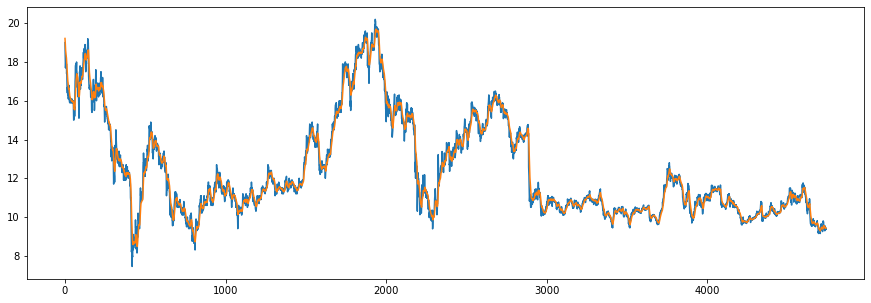

In [10]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 10, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 4302, 0.0: 215, 1.0: 213})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.333333333333333, 1: 7.419607843137255, 2: 0.3664536122409452}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2919 - accuracy: 0.4625 - mse: 0.4639 - weighted_accuracy: 0.3496 - weighted_mse: 0.5331 - val_loss: 0.3002 - val_accuracy: 0.0455 - val_mse: 0.3519 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3519
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2070 - accuracy: 0.2968 - mse: 0.7989 - weighted_accuracy: 0.4647 - weighted_mse: 0.7655 - val_loss: 0.2914 - val_accuracy: 0.0455 - val_mse: 0.3829 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3829
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1853 - accuracy: 0.2265 - mse: 1.0643 - weighted_accuracy: 0.5148 - weighted_mse: 1.0123 - val_loss: 0.2796 - val_accuracy: 0.0455 - val_mse: 0.4207 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4207
Epoch 4/20
30/30 [==============================] - 0s 7m

7/7 [==============================] - 0s 3ms/step - loss: 0.1812 - accuracy: 0.4047 - mse: 1.3665 - weighted_accuracy: 0.4047 - weighted_mse: 1.3665
Test loss: 0.18115724623203278
Test accuracy: 0.4046511650085449


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 74
actual holds but predicted sell: 48
actual predicted holds: 76
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 9.433962264150944%
Percentage holds correct: 93.82716049382717%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.148148148148145%
Percentage high sells correct: 64.15094339622641%
Percentage mid holds correct: 88.75%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase fro

30/30 [==============================] - 0s 7ms/step - loss: 0.1267 - accuracy: 0.5032 - mse: 1.7514 - weighted_accuracy: 0.7422 - weighted_mse: 1.7357 - val_loss: 0.1826 - val_accuracy: 0.4725 - val_mse: 1.8312 - val_weighted_accuracy: 0.4725 - val_weighted_mse: 1.8312
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1254 - accuracy: 0.4921 - mse: 1.7766 - weighted_accuracy: 0.7603 - weighted_mse: 1.7467 - val_loss: 0.1749 - val_accuracy: 0.4968 - val_mse: 1.7425 - val_weighted_accuracy: 0.4968 - val_weighted_mse: 1.7425
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1253 - accuracy: 0.4752 - mse: 1.8117 - weighted_accuracy: 0.7503 - weighted_mse: 1.7796 - val_loss: 0.1915 - val_accuracy: 0.4334 - val_mse: 1.8113 - val_weighted_accuracy: 0.4334 - val_weighted_mse: 1.8113
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.5053 - mse: 1.8199 - weighted_accuracy: 0.7614 - weighted_mse: 1.8054

0         -78.238355  



RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.5148 - mse: 1.8211 - weighted_accuracy: 0.7613 - weighted_mse: 1.8085 - val_loss: 0.1931 - val_accuracy: 0.4271 - val_mse: 1.8967 - val_weighted_accuracy: 0.4271 - val_weighted_mse: 1.8967
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.5011 - mse: 1.8484 - weighted_accuracy: 0.7469 - weighted_mse: 1.8332 - val_loss: 0.1749 - val_accuracy: 0.5211 - val_mse: 1.8577 - val_weighted_accuracy: 0.5211 - val_weighted_mse: 1.8577
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1209 - accuracy: 0.5148 - mse: 1.8415 - weighted_accuracy: 0.7723 - weighted_mse: 1.8254 - val_loss: 0.1679 - val_accuracy: 0.5486 - val_mse: 1.8428 - val_weighted_accuracy: 0.5486 - val_weighted_mse: 1.8428
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1199 - accuracy: 0.5032 - ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1901 - accuracy: 0.4930 - mse: 2.2959 - weighted_accuracy: 0.4930 - weighted_mse: 2.2959
Test loss: 0.19009429216384888
Test accuracy: 0.49302324652671814


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 65
actual holds but predicted sell: 35
actual predicted holds: 98
Percentage buys correct: 6.944444444444445%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.611111111111114%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 88.46153846153847%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price 

30/30 [==============================] - 0s 8ms/step - loss: 0.0978 - accuracy: 0.6710 - mse: 2.4030 - weighted_accuracy: 0.8387 - weighted_mse: 2.4956 - val_loss: 0.1909 - val_accuracy: 0.5465 - val_mse: 2.6145 - val_weighted_accuracy: 0.5465 - val_weighted_mse: 2.6145
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0975 - accuracy: 0.6678 - mse: 2.4647 - weighted_accuracy: 0.8357 - weighted_mse: 2.5565 - val_loss: 0.1881 - val_accuracy: 0.5539 - val_mse: 2.5276 - val_weighted_accuracy: 0.5539 - val_weighted_mse: 2.5276
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0943 - accuracy: 0.6734 - mse: 2.4469 - weighted_accuracy: 0.8526 - weighted_mse: 2.5154 - val_loss: 0.1866 - val_accuracy: 0.5243 - val_mse: 2.7439 - val_weighted_accuracy: 0.5243 - val_weighted_mse: 2.7439
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0931 - accuracy: 0.6599 - mse: 2.5071 - weighted_accuracy: 0.8587 - weighted_mse: 2.5880

Cash capital at the moment: $33.58159122216613


Share price: $0.05859812992484791
Shares owned at the moment: 571
Cash capital at the moment: $0.0300453215634775


Price increase from previously bought: 9.268879765218752%
Share price: $0.06420560131261242
Shares owned at the moment: 0
Cash capital at the moment: $36.59062482560404


Share price: $0.1427102898697593
Shares owned at the moment: 255
Cash capital at the moment: $0.09942531804424704


Price increase from previously bought: 14.093594044776925%
Share price: $0.16327106285578397
Shares owned at the moment: 0
Cash capital at the moment: $41.61905251344154


Share price: $0.1296261899649752
Shares owned at the moment: 320
Cash capital at the moment: $0.024600677480293598


Price increase from previously bought: -20.406349578198824%
Share price: $0.1034579455911858
Shares owned at the moment: 0
Cash capital at the moment: $33.040100274539505


Share price: $0.08663553142789203
Shares owned at the moment: 380
Cash capital at the 

30/30 [==============================] - 0s 8ms/step - loss: 0.0787 - accuracy: 0.7489 - mse: 3.0646 - weighted_accuracy: 0.8913 - weighted_mse: 3.2002 - val_loss: 0.1564 - val_accuracy: 0.6617 - val_mse: 3.1576 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 3.1576
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0784 - accuracy: 0.7542 - mse: 3.0924 - weighted_accuracy: 0.8951 - weighted_mse: 3.2096 - val_loss: 0.1561 - val_accuracy: 0.6776 - val_mse: 3.2348 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 3.2348
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.7344 - mse: 3.1804 - weighted_accuracy: 0.8879 - weighted_mse: 3.3141 - val_loss: 0.1736 - val_accuracy: 0.6300 - val_mse: 3.3059 - val_weighted_accuracy: 0.6300 - val_weighted_mse: 3.3059
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0754 - accuracy: 0.7600 - mse: 3.1672 - weighted_accuracy: 0.8973 - weighted_mse: 3.3195

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0747 - accuracy: 0.7637 - mse: 3.2313 - weighted_accuracy: 0.9005 - weighted_mse: 3.3625 - val_loss: 0.1898 - val_accuracy: 0.5793 - val_mse: 3.3310 - val_weighted_accuracy: 0.5793 - val_weighted_mse: 3.3310
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.7706 - mse: 3.2189 - weighted_accuracy: 0.9086 - weighted_mse: 3.3276 - val_loss: 0.1496 - val_accuracy: 0.7104 - val_mse: 3.3835 - val_weighted_accuracy: 0.7104 - val_weighted_mse: 3.3835
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.7611 - mse: 3.2320 - weighted_accuracy: 0.8995 - weighted_mse: 3.3466 - val_loss: 0.1468 - val_accuracy: 0.7230 - val_mse: 3.5790 - val_weighted_accuracy: 0.7230 - val_weighted_mse: 3.5790
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0733 - accuracy: 0.7566 - mse: 3.2978 - weighted_accuracy: 0.8979 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1549 - accuracy: 0.6977 - mse: 4.0464 - weighted_accuracy: 0.6977 - weighted_mse: 4.0464
Test loss: 0.15491031110286713
Test accuracy: 0.6976743936538696


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 33
actual holds but predicted sell: 18
actual predicted holds: 147
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 91.30434782608695%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 60.0%
Percentage high sells correct: 73.6842105263158%
Percentage mid holds correct: 85.625%


Capital: 100
Share price: $0.9726168574149023
Shares owned at the moment: 102
Cash capital at the moment: $0.5202615151750791


Price increase from previously 

Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0547 - accuracy: 0.8396 - mse: 4.6772 - weighted_accuracy: 0.9319 - weighted_mse: 4.7121 - val_loss: 0.1774 - val_accuracy: 0.6903 - val_mse: 4.7189 - val_weighted_accuracy: 0.6903 - val_weighted_mse: 4.7189
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.8351 - mse: 4.8297 - weighted_accuracy: 0.9359 - weighted_mse: 4.9087 - val_loss: 0.1819 - val_accuracy: 0.6998 - val_mse: 5.0763 - val_weighted_accuracy: 0.6998 - val_weighted_mse: 5.0763
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0517 - accuracy: 0.8480 - mse: 4.7920 - weighted_accuracy: 0.9369 - weighted_mse: 4.8622 - val_loss: 0.1655 - val_accuracy: 0.7516 - val_mse: 5.1273 - val_weighted_accuracy: 0.7516 - val_weighted_mse: 5.1273
Validation loss: 0.16553446650505066
Validation accuracy: 0.7515856027603149


Non-Recession Test


7/7 [==============================] - 0s 3ms/step 

Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0500 - accuracy: 0.8473 - mse: 5.0420 - weighted_accuracy: 0.9403 - weighted_mse: 5.0698 - val_loss: 0.1743 - val_accuracy: 0.7452 - val_mse: 5.8645 - val_weighted_accuracy: 0.7452 - val_weighted_mse: 5.8645
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0523 - accuracy: 0.8462 - mse: 5.0804 - weighted_accuracy: 0.9381 - weighted_mse: 5.0441 - val_loss: 0.1752 - val_accuracy: 0.7368 - val_mse: 5.5964 - val_weighted_accuracy: 0.7368 - val_weighted_mse: 5.5964
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0520 - accuracy: 0.8465 - mse: 5.1426 - weighted_accuracy: 0.9363 - weighted_mse: 5.1360 - val_loss: 0.1822 - val_accuracy: 0.7410 - val_mse: 5.6447 - val_weighted_accuracy: 0.7410 - val_weighted_mse: 5.6447
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0481 - accuracy: 0.8700 - mse: 5.1657 - weighted_accuracy: 0.9468 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.7442 - mse: 6.0242 - weighted_accuracy: 0.7442 - weighted_mse: 6.0242
Test loss: 0.16072481870651245
Test accuracy: 0.7441860437393188


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 27
actual holds but predicted sell: 13
actual predicted holds: 158
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 0.0%
Percentage holds correct: 91.32947976878613%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 58.62068965517241%
Percentage high sells correct: 69.23076923076923%
Percentage mid holds correct: 85.46511627906976%


Capital: 100
Share price: $0.9726168574149023
Shares owned at the moment: 102
Cash capital at the moment: $0.5202615151750791


Price increase from p

30/30 [==============================] - 0s 8ms/step - loss: 0.0372 - accuracy: 0.8990 - mse: 7.1062 - weighted_accuracy: 0.9612 - weighted_mse: 6.8388 - val_loss: 0.2098 - val_accuracy: 0.7368 - val_mse: 7.4464 - val_weighted_accuracy: 0.7368 - val_weighted_mse: 7.4464
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0351 - accuracy: 0.9051 - mse: 7.1365 - weighted_accuracy: 0.9634 - weighted_mse: 6.8507 - val_loss: 0.1942 - val_accuracy: 0.7780 - val_mse: 7.9011 - val_weighted_accuracy: 0.7780 - val_weighted_mse: 7.9011
Validation loss: 0.1942441612482071
Validation accuracy: 0.7780126929283142


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.7798 - mse: 7.4770 - weighted_accuracy: 0.7798 - weighted_mse: 7.4770
Test loss: 0.16291102766990662
Test accuracy: 0.7798165082931519


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sel

30/30 [==============================] - 0s 8ms/step - loss: 0.0361 - accuracy: 0.9057 - mse: 7.5079 - weighted_accuracy: 0.9636 - weighted_mse: 7.0522 - val_loss: 0.2085 - val_accuracy: 0.7505 - val_mse: 7.7150 - val_weighted_accuracy: 0.7505 - val_weighted_mse: 7.7150
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0367 - accuracy: 0.9049 - mse: 7.4698 - weighted_accuracy: 0.9559 - weighted_mse: 7.0860 - val_loss: 0.2079 - val_accuracy: 0.7844 - val_mse: 8.1077 - val_weighted_accuracy: 0.7844 - val_weighted_mse: 8.1077
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0321 - accuracy: 0.9202 - mse: 7.5841 - weighted_accuracy: 0.9671 - weighted_mse: 7.1141 - val_loss: 0.2064 - val_accuracy: 0.7558 - val_mse: 7.8542 - val_weighted_accuracy: 0.7558 - val_weighted_mse: 7.8542
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0313 - accuracy: 0.9239 - mse: 7.8001 - weighted_accuracy: 0.9684 - weighted_mse: 7.3609 - 

In [17]:
df = nr_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.504587,8.196721,10.204082,92.592593,53.333333,61.224490,80.555556,-63.545745,-64.1546
1,0.481651,11.290323,11.475410,95.789474,63.934426,54.098361,87.368421,-50.533139,-64.1546
2,0.536697,12.280702,10.000000,94.594595,57.894737,52.000000,84.545455,-25.633134,-64.1546
3,0.582569,13.043478,8.510638,93.600000,60.869565,48.936170,82.258065,-62.804928,-64.1546
4,0.623853,13.953488,7.692308,93.382353,62.790698,48.717949,82.962963,-38.521844,-64.1546
5,0.674312,10.344828,3.125000,91.082803,58.620690,43.750000,80.128205,-61.419526,-64.1546
6,0.747706,15.384615,4.761905,92.397661,61.538462,52.380952,79.411765,-7.849058,-64.1546
7,0.756881,17.391304,4.545455,92.485549,56.521739,50.000000,80.813953,-11.079547,-64.1546
8,0.779817,14.285714,5.882353,92.222222,57.142857,41.176471,79.888268,47.416229,-64.1546
9,0.788991,13.636364,7.142857,92.307692,54.545455,35.714286,80.110497,-45.438965,-64.1546


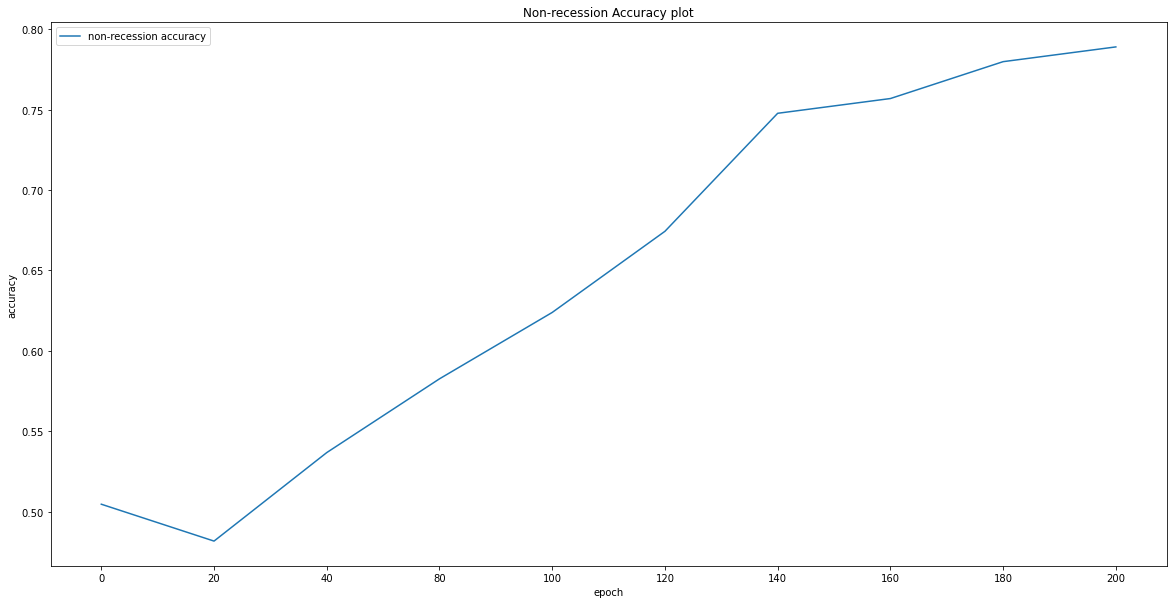

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

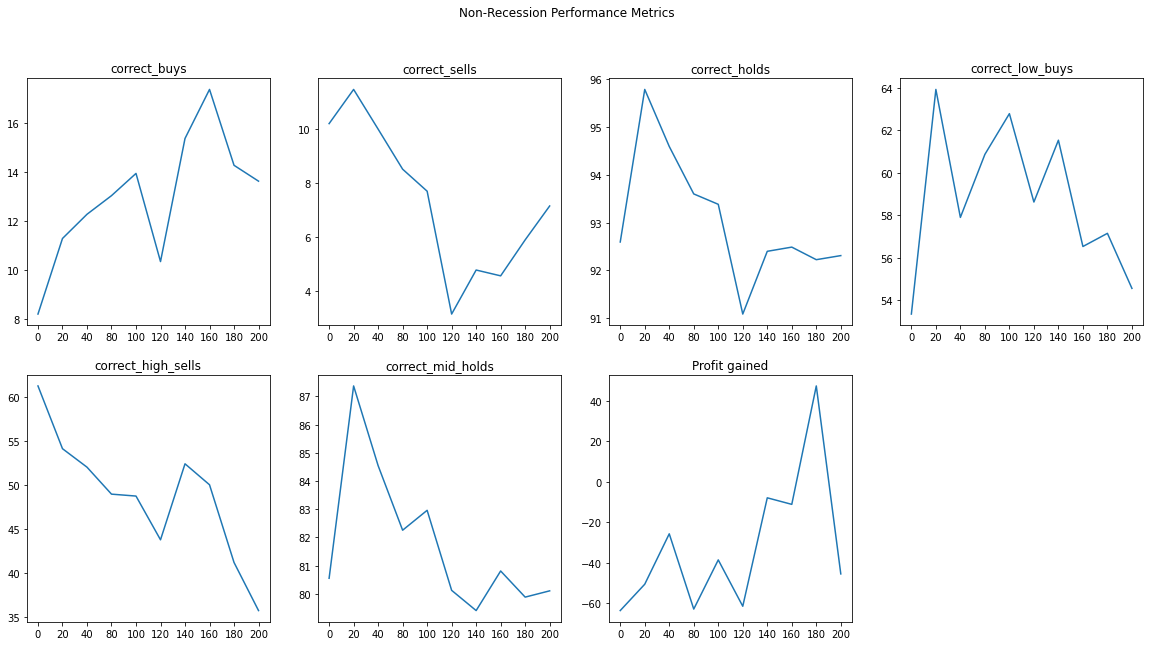

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

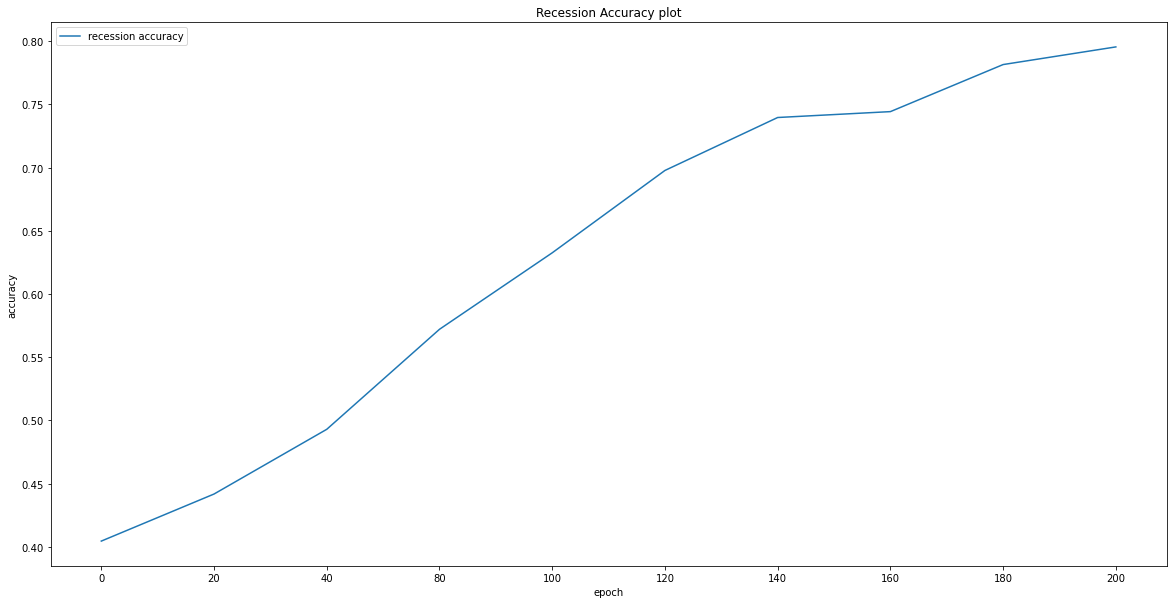

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

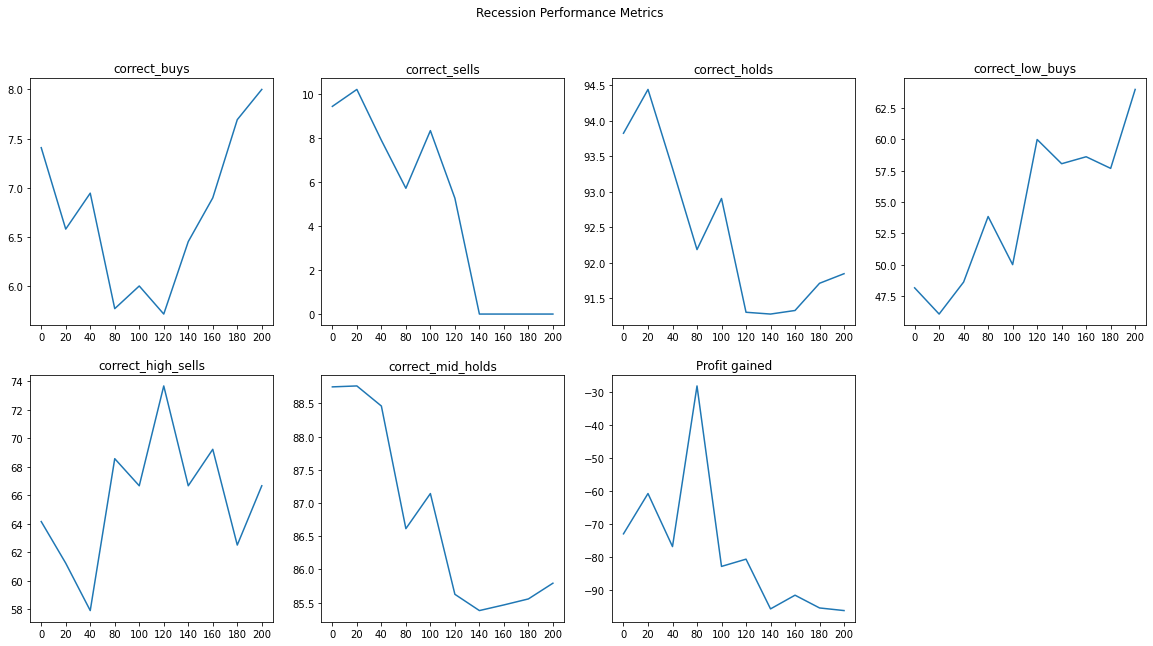

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [22]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-28        11.47  11.498850 -69.642815  18673351.0     2.0
2019-01-29        11.52  11.502104 -60.714201  22001151.0     2.0
2019-01-30        11.40  11.486395 -82.142942  18573051.0     2.0
2019-01-31        11.39  11.471565 -83.928529  15623051.0     2.0
2019-02-01        11.51  11.477478 -62.499957  23129851.0     2.0


In [23]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-30        10.91  11.040970 -69.565290  19391135.0     2.0
2020-01-31        10.92  11.022359 -67.391322  24795035.0     2.0
2020-02-03        10.83  10.992765 -83.333333  15850435.0     1.0
2020-02-04        10.71  10.949263 -98.113163   8263935.0     2.0
2020-02-05        10.85  10.933992 -71.697991  14379935.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


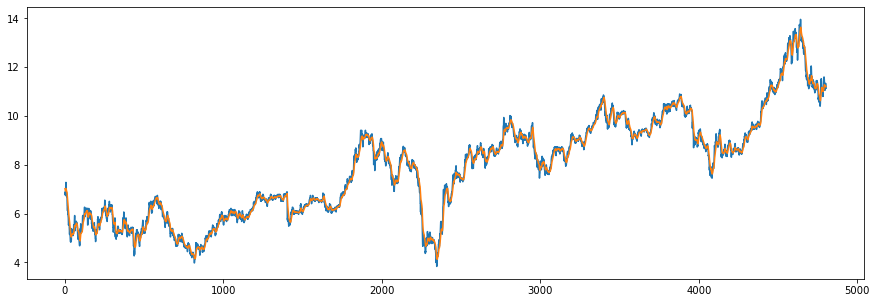

In [24]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 10, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.263257575757576, 1: 7.9399585921325055, 2: 0.3654469220506956}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2921 - accuracy: 0.4576 - mse: 0.4631 - weighted_accuracy: 0.3154 - weighted_mse: 0.5347 - val_loss: 0.2999 - val_accuracy: 0.0417 - val_mse: 0.3519 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3519
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.2656 - mse: 0.7785 - weighted_accuracy: 0.4703 - weighted_mse: 0.724 - 0s 9ms/step - loss: 0.2069 - accuracy: 0.2615 - mse: 0.7978 - weighted_accuracy: 0.4733 - weighted_mse: 0.7443 - val_loss: 0.2912 - val_accuracy: 0.0417 - val_mse: 0.3853 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3853
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1827 - accuracy: 0.2209 - mse: 1.0586 - weighted_accuracy: 0.5260 - weighted_mse: 0.9892 - val_loss: 0.2795 - val_accuracy: 0.0417 - val_mse: 0.4239 - val_w

7/7 [==============================] - 0s 5ms/step - loss: 0.1853 - accuracy: 0.2930 - mse: 1.4597 - weighted_accuracy: 0.2930 - weighted_mse: 1.4597
Test loss: 0.1853131651878357
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 64
actual holds but predicted sell: 81
actual predicted holds: 48
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 9.782608695652174%
Percentage holds correct: 90.56603773584905%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.857142857142854%
Percentage high sells correct: 55.43478260869565%
Percentage mid holds correct: 82.6923076923077%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price i

Epoch 14/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1269 - accuracy: 0.3890 - mse: 2.0755 - weighted_accuracy: 0.7429 - weighted_mse: 2.0092 - val_loss: 0.1851 - val_accuracy: 0.3691 - val_mse: 2.0569 - val_weighted_accuracy: 0.3691 - val_weighted_mse: 2.0569
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1266 - accuracy: 0.4329 - mse: 2.0366 - weighted_accuracy: 0.7554 - weighted_mse: 1.9963 - val_loss: 0.1996 - val_accuracy: 0.3222 - val_mse: 2.0702 - val_weighted_accuracy: 0.3222 - val_weighted_mse: 2.0702
Epoch 16/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.4029 - mse: 2.0861 - weighted_accuracy: 0.7478 - weighted_mse: 2.0253 - val_loss: 0.2025 - val_accuracy: 0.2982 - val_mse: 2.1105 - val_weighted_accuracy: 0.2982 - val_weighted_mse: 2.1105
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1237 - accuracy: 0.4253 - mse: 2.1200 - weighted_accuracy: 0.7583 - weigh

30/30 [==============================] - 0s 15ms/step - loss: 0.1207 - accuracy: 0.4683 - mse: 2.1820 - weighted_accuracy: 0.7721 - weighted_mse: 2.1507 - val_loss: 0.1854 - val_accuracy: 0.4150 - val_mse: 2.1584 - val_weighted_accuracy: 0.4150 - val_weighted_mse: 2.1584
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1202 - accuracy: 0.4441 - mse: 2.2480 - weighted_accuracy: 0.7629 - weighted_mse: 2.1963 - val_loss: 0.1771 - val_accuracy: 0.4254 - val_mse: 2.2661 - val_weighted_accuracy: 0.4254 - val_weighted_mse: 2.2661
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1188 - accuracy: 0.4618 - mse: 2.2536 - weighted_accuracy: 0.7681 - weighted_mse: 2.2313 - val_loss: 0.1868 - val_accuracy: 0.3994 - val_mse: 2.2638 - val_weighted_accuracy: 0.3994 - val_weighted_mse: 2.2638
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1191 - accuracy: 0.4803 - mse: 2.2521 - weighted_accuracy: 0.7837 - weighted_mse: 2.232

7/7 [==============================] - 0s 5ms/step - loss: 0.1861 - accuracy: 0.4419 - mse: 2.9049 - weighted_accuracy: 0.4419 - weighted_mse: 2.9049
Test loss: 0.18606223165988922
Test accuracy: 0.44186046719551086


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 52
actual holds but predicted sell: 57
actual predicted holds: 84
Percentage buys correct: 5.357142857142857%
Percentage sells correct: 12.121212121212121%
Percentage holds correct: 90.3225806451613%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously 

Epoch 11/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0987 - accuracy: 0.6044 - mse: 2.9635 - weighted_accuracy: 0.8312 - weighted_mse: 3.0564 - val_loss: 0.1962 - val_accuracy: 0.4911 - val_mse: 3.0834 - val_weighted_accuracy: 0.4911 - val_weighted_mse: 3.0834
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0982 - accuracy: 0.5990 - mse: 2.9659 - weighted_accuracy: 0.8344 - weighted_mse: 3.0620 - val_loss: 0.1814 - val_accuracy: 0.5109 - val_mse: 3.1397 - val_weighted_accuracy: 0.5109 - val_weighted_mse: 3.1397
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0979 - accuracy: 0.6151 - mse: 2.9903 - weighted_accuracy: 0.8354 - weighted_mse: 3.0499 - val_loss: 0.1746 - val_accuracy: 0.5162 - val_mse: 3.0930 - val_weighted_accuracy: 0.5162 - val_weighted_mse: 3.0930
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0956 - accuracy: 0.6193 - mse: 3.0810 - weighted_accuracy: 0.8420 - weigh

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0905 - accuracy: 0.6683 - mse: 3.2140 - weighted_accuracy: 0.8563 - weighted_mse: 3.3268 - val_loss: 0.1706 - val_accuracy: 0.5641 - val_mse: 3.3967 - val_weighted_accuracy: 0.5641 - val_weighted_mse: 3.3967
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0900 - accuracy: 0.6511 - mse: 3.2778 - weighted_accuracy: 0.8558 - weighted_mse: 3.3614 - val_loss: 0.1778 - val_accuracy: 0.5506 - val_mse: 3.3155 - val_weighted_accuracy: 0.5506 - val_weighted_mse: 3.3155
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0881 - accuracy: 0.6550 - mse: 3.3211 - weighted_accuracy: 0.8590 - weighted_mse: 3.4488 - val_loss: 0.1750 - val_accuracy: 0.5631 - val_mse: 3.2962 - val_weighted_accuracy: 0.5631 - val_weighted_mse: 3.2962
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0895 - accuracy: 0.6701 - mse: 3.3802 - weighted_accuracy: 0.8516 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1972 - accuracy: 0.6000 - mse: 4.4100 - weighted_accuracy: 0.6000 - weighted_mse: 4.4100
Test loss: 0.19717341661453247
Test accuracy: 0.6000000238418579


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 34
actual holds but predicted sell: 39
actual predicted holds: 120
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 15.217391304347826%
Percentage holds correct: 90.22556390977444%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 65.21739130434783%
Percentage mid holds correct: 85.60606060606061%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Pri

Epoch 14/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0661 - accuracy: 0.7794 - mse: 4.7335 - weighted_accuracy: 0.9084 - weighted_mse: 4.8426 - val_loss: 0.1392 - val_accuracy: 0.7602 - val_mse: 5.1282 - val_weighted_accuracy: 0.7602 - val_weighted_mse: 5.1282
Epoch 15/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0676 - accuracy: 0.7708 - mse: 4.6291 - weighted_accuracy: 0.9017 - weighted_mse: 4.7774 - val_loss: 0.1763 - val_accuracy: 0.6184 - val_mse: 5.0502 - val_weighted_accuracy: 0.6184 - val_weighted_mse: 5.0502
Epoch 16/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0655 - accuracy: 0.7825 - mse: 4.7886 - weighted_accuracy: 0.9092 - weighted_mse: 4.9126 - val_loss: 0.1656 - val_accuracy: 0.6444 - val_mse: 4.9840 - val_weighted_accuracy: 0.6444 - val_weighted_mse: 4.9840
Epoch 17/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0651 - accuracy: 0.7906 - mse: 4.8228 - weighted_accuracy: 0.9104 - weig

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0619 - accuracy: 0.8078 - mse: 5.0182 - weighted_accuracy: 0.9244 - weighted_mse: 5.0988 - val_loss: 0.1552 - val_accuracy: 0.7039 - val_mse: 5.2584 - val_weighted_accuracy: 0.7039 - val_weighted_mse: 5.2584
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0619 - accuracy: 0.7958 - mse: 5.0474 - weighted_accuracy: 0.9160 - weighted_mse: 5.0853 - val_loss: 0.1721 - val_accuracy: 0.6496 - val_mse: 5.3448 - val_weighted_accuracy: 0.6496 - val_weighted_mse: 5.3448
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0601 - accuracy: 0.8039 - mse: 5.1875 - weighted_accuracy: 0.9208 - weighted_mse: 5.2830 - val_loss: 0.1740 - val_accuracy: 0.6653 - val_mse: 5.1663 - val_weighted_accuracy: 0.6653 - val_weighted_mse: 5.1663
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0614 - accuracy: 0.8099 - mse: 5.2746 - weighted_accuracy: 0.9194 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.2383 - accuracy: 0.6884 - mse: 6.9597 - weighted_accuracy: 0.6884 - weighted_mse: 6.9597
Test loss: 0.23832854628562927
Test accuracy: 0.6883720755577087


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 19
actual holds but predicted sell: 33
actual predicted holds: 141
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 13.157894736842104%
Percentage holds correct: 90.38461538461539%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 61.904761904761905%
Percentage high sells correct: 63.1578947368421%
Percentage mid holds correct: 86.45161290322581%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Pri

30/30 [==============================] - 0s 14ms/step - loss: 0.0425 - accuracy: 0.8881 - mse: 7.3673 - weighted_accuracy: 0.9516 - weighted_mse: 7.1639 - val_loss: 0.1624 - val_accuracy: 0.7539 - val_mse: 7.5644 - val_weighted_accuracy: 0.7539 - val_weighted_mse: 7.5644
Epoch 18/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0415 - accuracy: 0.8866 - mse: 7.4659 - weighted_accuracy: 0.9550 - weighted_mse: 7.2030 - val_loss: 0.1723 - val_accuracy: 0.7414 - val_mse: 7.5448 - val_weighted_accuracy: 0.7414 - val_weighted_mse: 7.5448
Epoch 19/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0410 - accuracy: 0.8868 - mse: 7.6235 - weighted_accuracy: 0.9568 - weighted_mse: 7.3331 - val_loss: 0.1696 - val_accuracy: 0.7456 - val_mse: 7.9469 - val_weighted_accuracy: 0.7456 - val_weighted_mse: 7.9469
Epoch 20/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0431 - accuracy: 0.8681 - mse: 7.5622 - weighted_accuracy: 0.9480 - weighted_mse: 7.

30/30 [==============================] - 0s 12ms/step - loss: 0.0405 - accuracy: 0.8967 - mse: 7.7478 - weighted_accuracy: 0.9605 - weighted_mse: 7.4258 - val_loss: 0.1631 - val_accuracy: 0.7748 - val_mse: 8.4136 - val_weighted_accuracy: 0.7748 - val_weighted_mse: 8.4136
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0405 - accuracy: 0.8814 - mse: 7.6761 - weighted_accuracy: 0.9566 - weighted_mse: 7.3388 - val_loss: 0.1758 - val_accuracy: 0.7195 - val_mse: 7.8549 - val_weighted_accuracy: 0.7195 - val_weighted_mse: 7.8549
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.8941 - mse: 7.9076 - weighted_accuracy: 0.9577 - weighted_mse: 7.6126 - val_loss: 0.1801 - val_accuracy: 0.7205 - val_mse: 7.9821 - val_weighted_accuracy: 0.7205 - val_weighted_mse: 7.9821
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.8939 - mse: 8.0140 - weighted_accuracy: 0.9612 - weighted_mse: 7.6602 -

7/7 [==============================] - 0s 3ms/step - loss: 0.2774 - accuracy: 0.7070 - mse: 9.6975 - weighted_accuracy: 0.7070 - weighted_mse: 9.6975
Test loss: 0.27737662196159363
Test accuracy: 0.7069767713546753


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 16
actual holds but predicted sell: 33
actual predicted holds: 144
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 91.13924050632912%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 64.1025641025641%
Percentage mid holds correct: 87.26114649681529%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Pric

Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9374 - mse: 10.9426 - weighted_accuracy: 0.9753 - weighted_mse: 9.9241 - val_loss: 0.2076 - val_accuracy: 0.7612 - val_mse: 11.0844 - val_weighted_accuracy: 0.7612 - val_weighted_mse: 11.0844
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0272 - accuracy: 0.9319 - mse: 11.2229 - weighted_accuracy: 0.9733 - weighted_mse: 10.1801 - val_loss: 0.2056 - val_accuracy: 0.7623 - val_mse: 11.6574 - val_weighted_accuracy: 0.7623 - val_weighted_mse: 11.6574
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 0.9231 - mse: 11.0787 - weighted_accuracy: 0.9699 - weighted_mse: 10.1076 - val_loss: 0.2080 - val_accuracy: 0.7289 - val_mse: 10.7224 - val_weighted_accuracy: 0.7289 - val_weighted_mse: 10.7224
Validation loss: 0.20795926451683044
Validation accuracy: 0.7288842797279358


Non-Recession Test


7/7 [==============================] - 0

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.293023,8.571429,9.782609,90.566038,52.857143,55.434783,82.692308,-50.824750,-24.56292
1,0.381395,4.761905,12.162162,89.743590,53.968254,60.273973,85.897436,-44.062673,-24.56292
2,0.441860,5.357143,12.121212,90.322581,50.000000,60.000000,87.096774,-29.601662,-24.56292
3,0.539535,6.122449,16.000000,90.517241,46.938776,66.000000,86.956522,-27.326721,-24.56292
4,0.600000,5.555556,15.217391,90.225564,47.222222,65.217391,85.606061,-37.929757,-24.56292
5,0.651163,7.407407,15.909091,90.972222,59.259259,65.909091,86.713287,-35.097652,-24.56292
6,0.688372,9.523810,13.157895,90.384615,61.904762,63.157895,86.451613,-42.021433,-24.56292
7,0.706977,11.764706,15.000000,91.139241,64.705882,65.000000,87.261146,-40.951012,-24.56292
8,0.706977,11.111111,15.384615,91.139241,66.666667,64.102564,87.261146,-38.010994,-24.56292
9,0.730233,9.090909,13.513514,90.419162,54.545455,62.162162,86.746988,-51.729697,-24.56292


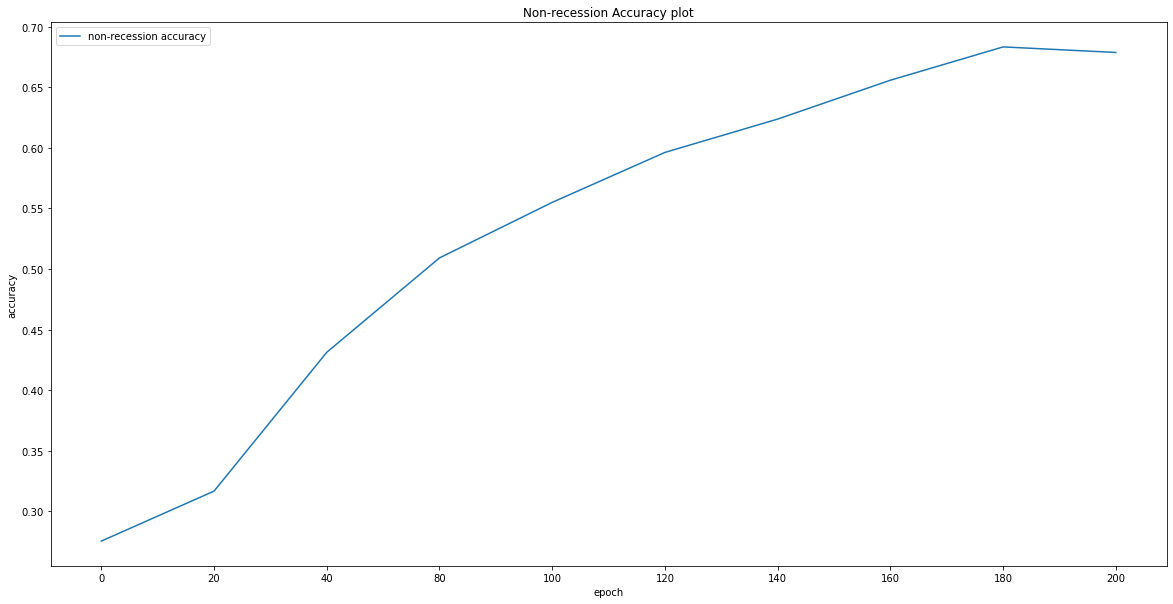

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

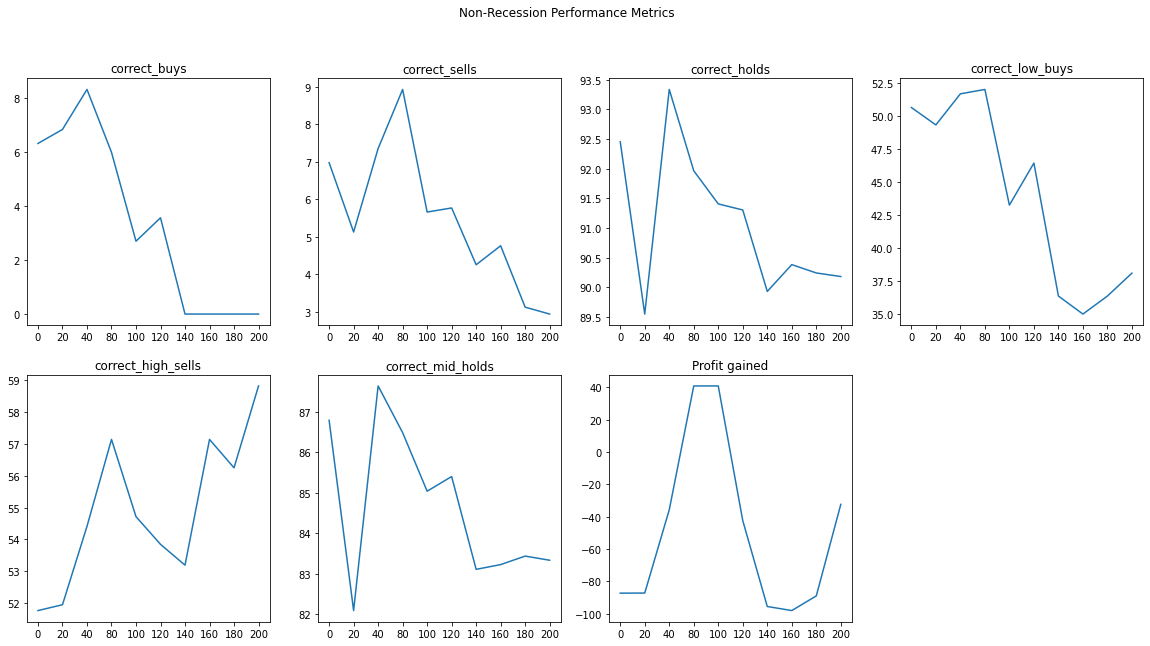

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

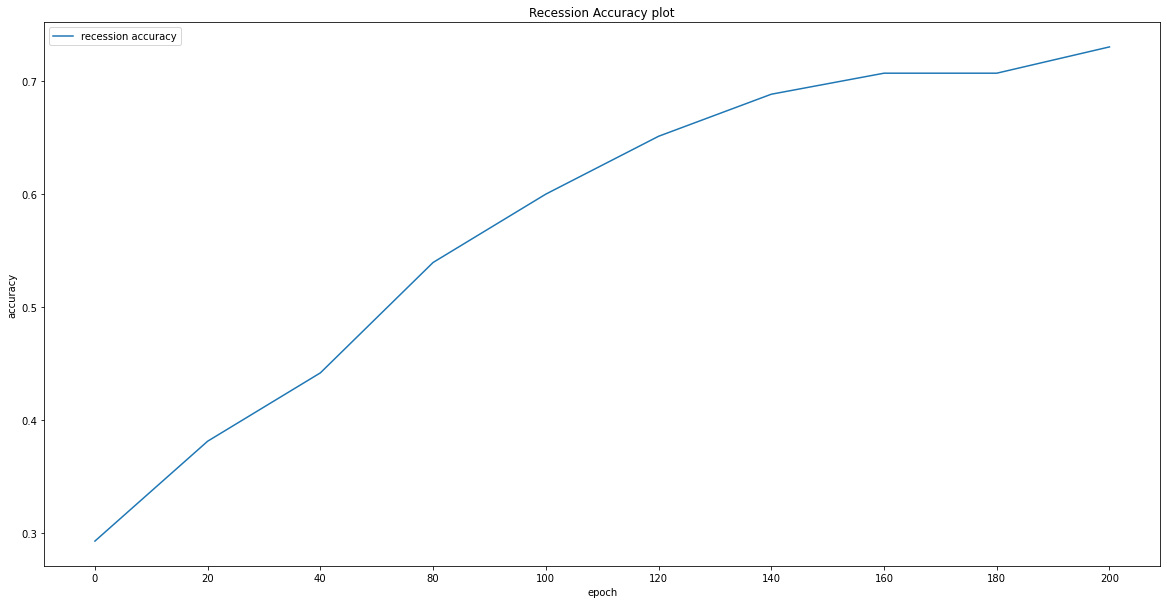

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

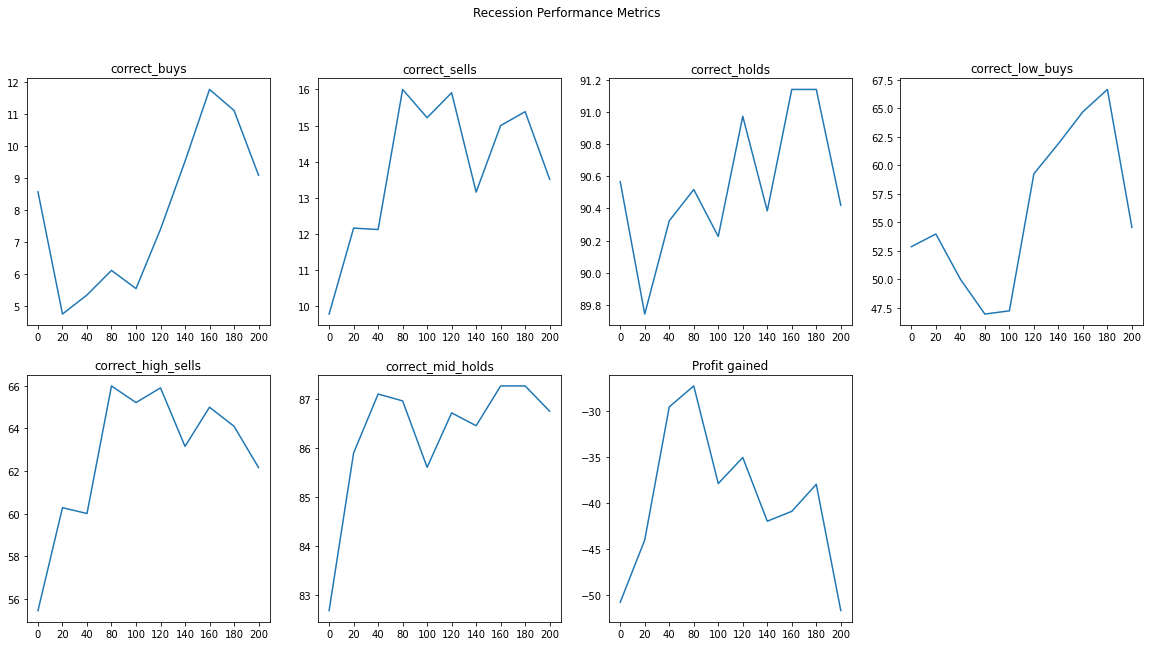

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [35]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-29        13.04  12.757552 -13.725518  456517506.0     2.0
2019-01-30        12.64  12.739468 -52.941149  367199487.0     2.0
2019-01-31        12.80  12.748780 -37.254896  419227428.0     2.0
2019-02-01        13.12  12.805891  -5.882391  486899235.0     2.0
2019-02-04        13.22  12.869600  -6.818120  532291174.0     2.0


In [36]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-31        12.00  12.977839 -94.680831  -24968864.0     2.0
2020-02-03        11.86  12.805864 -97.959186  -90556668.0     1.0
2020-02-04        11.68  12.632654 -96.330278 -150958086.0     2.0
2020-02-05        11.80  12.504553 -86.842095  -75225791.0     2.0
2020-02-06        12.00  12.426930 -76.851850   12002801.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


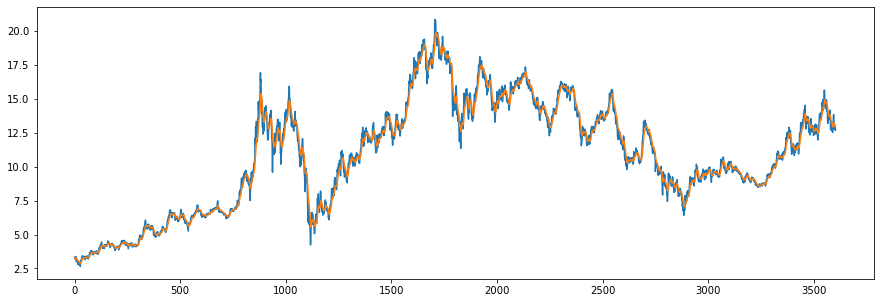

In [37]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 10, 4)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.262626262626263, 1: 7.374358974358974, 2: 0.3667431777607753}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 1s 41ms/step - loss: 0.3009 - accuracy: 0.4955 - mse: 0.4333 - weighted_accuracy: 0.3322 - weighted_mse: 0.5248 - val_loss: 0.3011 - val_accuracy: 0.0459 - val_mse: 0.3469 - val_weighted_accuracy: 0.0459 - val_weighted_mse: 0.3469
Epoch 2/20
23/23 [==============================] - 0s 10ms/step - loss: 0.2190 - accuracy: 0.3202 - mse: 0.6939 - weighted_accuracy: 0.4538 - weighted_mse: 0.6852 - val_loss: 0.2959 - val_accuracy: 0.0445 - val_mse: 0.3662 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.3662
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1911 - accuracy: 0.2410 - mse: 0.9290 - weighted_accuracy: 0.5165 - weighted_mse: 0.8874 - val_loss: 0.2874 - val_accuracy: 0.0445 - val_mse: 0.3888 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.3888
Epoch 4/20
23/23 [==============================] - 0s 1

7/7 [==============================] - 0s 4ms/step - loss: 0.1619 - accuracy: 0.7183 - mse: 1.1323 - weighted_accuracy: 0.7183 - weighted_mse: 1.1323
Test loss: 0.16192469000816345
Test accuracy: 0.7183098793029785


number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 31
actual predicted holds: 150
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 3.125%
Percentage holds correct: 89.82035928143712%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 64.28571428571429%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 82.63473053892216%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase f

Validation loss: 0.19062469899654388
Validation accuracy: 0.415855348110199


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.3744 - mse: 1.8152 - weighted_accuracy: 0.3744 - weighted_mse: 1.8152
Test loss: 0.19809292256832123
Test accuracy: 0.3744075894355774


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 59
actual predicted holds: 70
Percentage buys correct: 5.633802816901408%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 59.15492957746479%
Percentage high sells correct: 57.8125%
Percentage mid holds correct: 81.33333333333333%


Capital: 100
Share price: $0.6782927975265876


Epoch 1/20
23/23 [==============================] - 0s 11ms/step - loss: 0.1240 - accuracy: 0.4882 - mse: 1.8297 - weighted_accuracy: 0.7591 - weighted_mse: 1.8116 - val_loss: 0.1862 - val_accuracy: 0.4200 - val_mse: 1.9269 - val_weighted_accuracy: 0.4200 - val_weighted_mse: 1.9269
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1230 - accuracy: 0.4830 - mse: 1.8387 - weighted_accuracy: 0.7718 - weighted_mse: 1.8223 - val_loss: 0.1820 - val_accuracy: 0.4590 - val_mse: 1.8900 - val_weighted_accuracy: 0.4590 - val_weighted_mse: 1.8900
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1222 - accuracy: 0.4986 - mse: 1.8368 - weighted_accuracy: 0.7655 - weighted_mse: 1.8214 - val_loss: 0.1749 - val_accuracy: 0.5146 - val_mse: 1.8830 - val_weighted_accuracy: 0.5146 - val_weighted_mse: 1.8830
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.1223 - accuracy: 0.5087 - mse: 1.8871 - weighted_accuracy: 0.7500 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.5023 - mse: 2.2968 - weighted_accuracy: 0.5023 - weighted_mse: 2.2968
Test loss: 0.18914881348609924
Test accuracy: 0.5023474097251892


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 46
actual holds but predicted sell: 51
actual predicted holds: 96
Percentage buys correct: 11.538461538461538%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 93.20388349514563%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 84.46601941747574%


Capital: 100
Share price: $0.8786869149061622
Shares owned at the moment: 113
Cash capital at the moment: $0.4353266567965761


Price

23/23 [==============================] - 0s 8ms/step - loss: 0.1010 - accuracy: 0.6248 - mse: 2.3057 - weighted_accuracy: 0.8407 - weighted_mse: 2.4099 - val_loss: 0.1837 - val_accuracy: 0.5410 - val_mse: 2.4757 - val_weighted_accuracy: 0.5410 - val_weighted_mse: 2.4757
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0988 - accuracy: 0.6582 - mse: 2.3204 - weighted_accuracy: 0.8457 - weighted_mse: 2.4367 - val_loss: 0.1639 - val_accuracy: 0.6078 - val_mse: 2.5694 - val_weighted_accuracy: 0.6078 - val_weighted_mse: 2.5694
Epoch 13/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0988 - accuracy: 0.6488 - mse: 2.3627 - weighted_accuracy: 0.8446 - weighted_mse: 2.4853 - val_loss: 0.1658 - val_accuracy: 0.5967 - val_mse: 2.5728 - val_weighted_accuracy: 0.5967 - val_weighted_mse: 2.5728
Epoch 14/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0975 - accuracy: 0.6679 - mse: 2.3826 - weighted_accuracy: 0.8638 - weighted_mse: 2.5115

Epoch 1/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0918 - accuracy: 0.6818 - mse: 2.5381 - weighted_accuracy: 0.8615 - weighted_mse: 2.7100 - val_loss: 0.1809 - val_accuracy: 0.5563 - val_mse: 2.6658 - val_weighted_accuracy: 0.5563 - val_weighted_mse: 2.6658
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0905 - accuracy: 0.6732 - mse: 2.5676 - weighted_accuracy: 0.8681 - weighted_mse: 2.7373 - val_loss: 0.1704 - val_accuracy: 0.5925 - val_mse: 2.6511 - val_weighted_accuracy: 0.5925 - val_weighted_mse: 2.6511
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0906 - accuracy: 0.6971 - mse: 2.5606 - weighted_accuracy: 0.8720 - weighted_mse: 2.7206 - val_loss: 0.1582 - val_accuracy: 0.6453 - val_mse: 2.7192 - val_weighted_accuracy: 0.6453 - val_weighted_mse: 2.7192
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0910 - accuracy: 0.6818 - mse: 2.6417 - weighted_accuracy: 0.8616 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.6056 - mse: 3.0449 - weighted_accuracy: 0.6056 - weighted_mse: 3.0449
Test loss: 0.17984965443611145
Test accuracy: 0.6056337952613831


number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 39
actual holds but predicted sell: 34
actual predicted holds: 120
Percentage buys correct: 11.363636363636363%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 91.6030534351145%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 65.9090909090909%
Percentage high sells correct: 56.75675675675676%
Percentage mid holds correct: 82.44274809160305%


Capital: 100
Share price: $0.8786869149061622
Shares owned at the moment: 113
Cash capital at the moment: $0.4353266567965761


Price

23/23 [==============================] - 0s 8ms/step - loss: 0.0690 - accuracy: 0.7952 - mse: 3.3586 - weighted_accuracy: 0.9225 - weighted_mse: 3.6300 - val_loss: 0.1549 - val_accuracy: 0.6926 - val_mse: 3.8258 - val_weighted_accuracy: 0.6926 - val_weighted_mse: 3.8258
Epoch 13/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0704 - accuracy: 0.7813 - mse: 3.4254 - weighted_accuracy: 0.9053 - weighted_mse: 3.7113 - val_loss: 0.1628 - val_accuracy: 0.6773 - val_mse: 3.6987 - val_weighted_accuracy: 0.6773 - val_weighted_mse: 3.6987
Epoch 14/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0685 - accuracy: 0.7962 - mse: 3.4350 - weighted_accuracy: 0.9132 - weighted_mse: 3.7123 - val_loss: 0.1549 - val_accuracy: 0.7038 - val_mse: 4.0266 - val_weighted_accuracy: 0.7038 - val_weighted_mse: 4.0266
Epoch 15/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0687 - accuracy: 0.7771 - mse: 3.5505 - weighted_accuracy: 0.9086 - weighted_mse: 3.8244

Price increase from previously bought: 46.856837531320615%
Share price: $0.5403030412497052
Shares owned at the moment: 0
Cash capital at the moment: $34.696559768064894


Share price: $0.4190908762508847
Shares owned at the moment: 82
Cash capital at the moment: $0.23660292289777374


Price increase from previously bought: 5.334190257925453%
Share price: $0.44265995739130903
Shares owned at the moment: 0
Cash capital at the moment: $36.43489960859337


Share price: $0.3786868747683543
Shares owned at the moment: 95
Cash capital at the moment: $0.3607145595664818


Price increase from previously bought: 17.902842708389933%
Share price: $0.4477104174388178
Shares owned at the moment: 0
Cash capital at the moment: $42.77623986969828


Share price: $0.38037041496793456
Shares owned at the moment: 112
Cash capital at the moment: $0.057599305479485


Price increase from previously bought: 1.9326281210604979%
Share price: $0.3887877948633718
Shares owned at the moment: 0
Cash capital at the 

23/23 [==============================] - 0s 8ms/step - loss: 0.0555 - accuracy: 0.8369 - mse: 4.4419 - weighted_accuracy: 0.9306 - weighted_mse: 4.7870 - val_loss: 0.1991 - val_accuracy: 0.6551 - val_mse: 4.8793 - val_weighted_accuracy: 0.6551 - val_weighted_mse: 4.8793
Epoch 19/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0549 - accuracy: 0.8401 - mse: 4.4842 - weighted_accuracy: 0.9317 - weighted_mse: 4.7855 - val_loss: 0.1517 - val_accuracy: 0.7719 - val_mse: 5.1047 - val_weighted_accuracy: 0.7719 - val_weighted_mse: 5.1047
Epoch 20/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0522 - accuracy: 0.8484 - mse: 4.5617 - weighted_accuracy: 0.9444 - weighted_mse: 4.9003 - val_loss: 0.1612 - val_accuracy: 0.7260 - val_mse: 4.8043 - val_weighted_accuracy: 0.7260 - val_weighted_mse: 4.8043
Validation loss: 0.161234512925148
Validation accuracy: 0.7260083556175232


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1726




RUNNING EPOCHS 140 - 160



Epoch 1/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0504 - accuracy: 0.8644 - mse: 4.5713 - weighted_accuracy: 0.9430 - weighted_mse: 4.9285 - val_loss: 0.1903 - val_accuracy: 0.6759 - val_mse: 4.6674 - val_weighted_accuracy: 0.6759 - val_weighted_mse: 4.6674
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0486 - accuracy: 0.8630 - mse: 4.6135 - weighted_accuracy: 0.9498 - weighted_mse: 4.9551 - val_loss: 0.1542 - val_accuracy: 0.7385 - val_mse: 4.8943 - val_weighted_accuracy: 0.7385 - val_weighted_mse: 4.8943
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0503 - accuracy: 0.8634 - mse: 4.6952 - weighted_accuracy: 0.9475 - weighted_mse: 4.9914 - val_loss: 0.1592 - val_accuracy: 0.7399 - val_mse: 5.0614 - val_weighted_accuracy: 0.7399 - val_weighted_mse: 5.0614
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 0.8561 - mse: 4.8357 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.7324 - mse: 5.7525 - weighted_accuracy: 0.7324 - weighted_mse: 5.7525
Test loss: 0.17592355608940125
Test accuracy: 0.7323943376541138


number of predictions: 213
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 16
actual holds but predicted sell: 26
actual predicted holds: 151
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 90.96385542168674%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 76.47058823529412%
Percentage high sells correct: 65.51724137931035%
Percentage mid holds correct: 83.73493975903614%


Capital: 100
Share price: $0.8786869149061622
Shares owned at the moment: 113
Cash capital at the moment: $0.4353266567965761


Pric

Epoch 16/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.8995 - mse: 6.5603 - weighted_accuracy: 0.9535 - weighted_mse: 6.7556 - val_loss: 0.2047 - val_accuracy: 0.6898 - val_mse: 7.0609 - val_weighted_accuracy: 0.6898 - val_weighted_mse: 7.0609
Epoch 17/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0372 - accuracy: 0.9061 - mse: 6.5491 - weighted_accuracy: 0.9583 - weighted_mse: 6.7183 - val_loss: 0.2157 - val_accuracy: 0.6954 - val_mse: 7.1755 - val_weighted_accuracy: 0.6954 - val_weighted_mse: 7.1755
Epoch 18/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0377 - accuracy: 0.9023 - mse: 6.6721 - weighted_accuracy: 0.9618 - weighted_mse: 6.8232 - val_loss: 0.2412 - val_accuracy: 0.6815 - val_mse: 7.1615 - val_weighted_accuracy: 0.6815 - val_weighted_mse: 7.1615
Epoch 19/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 0.9155 - mse: 6.7402 - weighted_accuracy: 0.9666 - weighted

Epoch 1/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0323 - accuracy: 0.9280 - mse: 6.8419 - weighted_accuracy: 0.9736 - weighted_mse: 6.9705 - val_loss: 0.2037 - val_accuracy: 0.7107 - val_mse: 6.6410 - val_weighted_accuracy: 0.7107 - val_weighted_mse: 6.6410
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0303 - accuracy: 0.9270 - mse: 6.8847 - weighted_accuracy: 0.9732 - weighted_mse: 6.9740 - val_loss: 0.1739 - val_accuracy: 0.8067 - val_mse: 7.6281 - val_weighted_accuracy: 0.8067 - val_weighted_mse: 7.6281
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0321 - accuracy: 0.9263 - mse: 7.0485 - weighted_accuracy: 0.9706 - weighted_mse: 7.0602 - val_loss: 0.1762 - val_accuracy: 0.7955 - val_mse: 7.4459 - val_weighted_accuracy: 0.7955 - val_weighted_mse: 7.4459
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0330 - accuracy: 0.9242 - mse: 7.2141 - weighted_accuracy: 0.9650 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.7981 - mse: 9.3387 - weighted_accuracy: 0.7981 - weighted_mse: 9.3387
Test loss: 0.19327284395694733
Test accuracy: 0.7981220483779907


number of predictions: 213
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 9
actual holds but predicted sell: 17
actual predicted holds: 167
Percentage buys correct: 10.0%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 90.76086956521739%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 70.0%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 83.15217391304348%


Capital: 100
Share price: $0.8786869149061622
Shares owned at the moment: 113
Cash capital at the moment: $0.4353266567965761


Price increase from previously

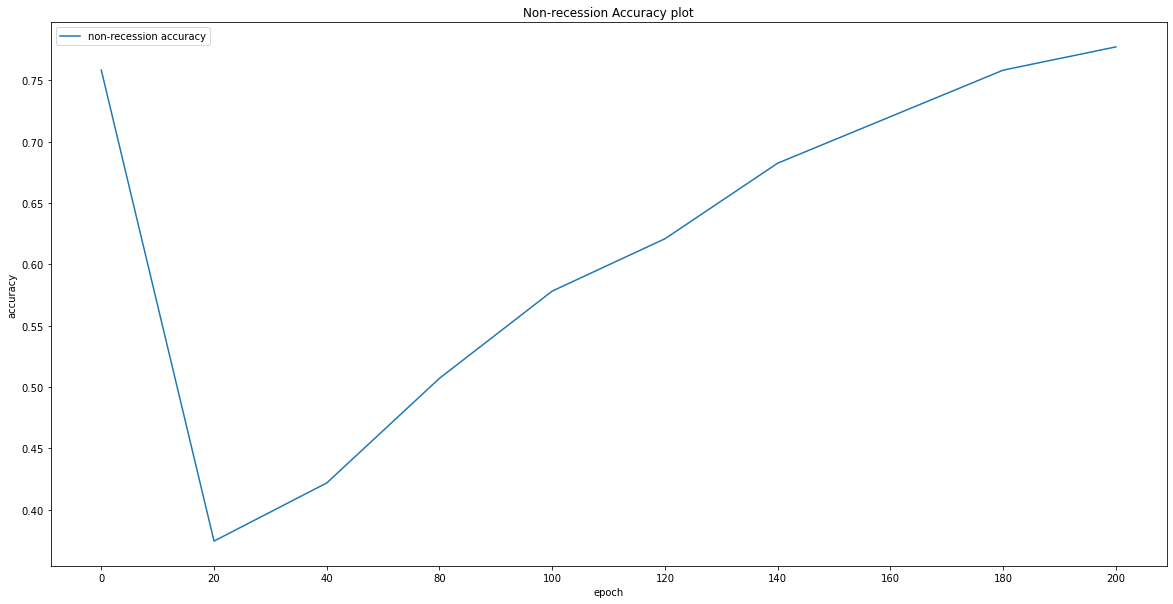

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

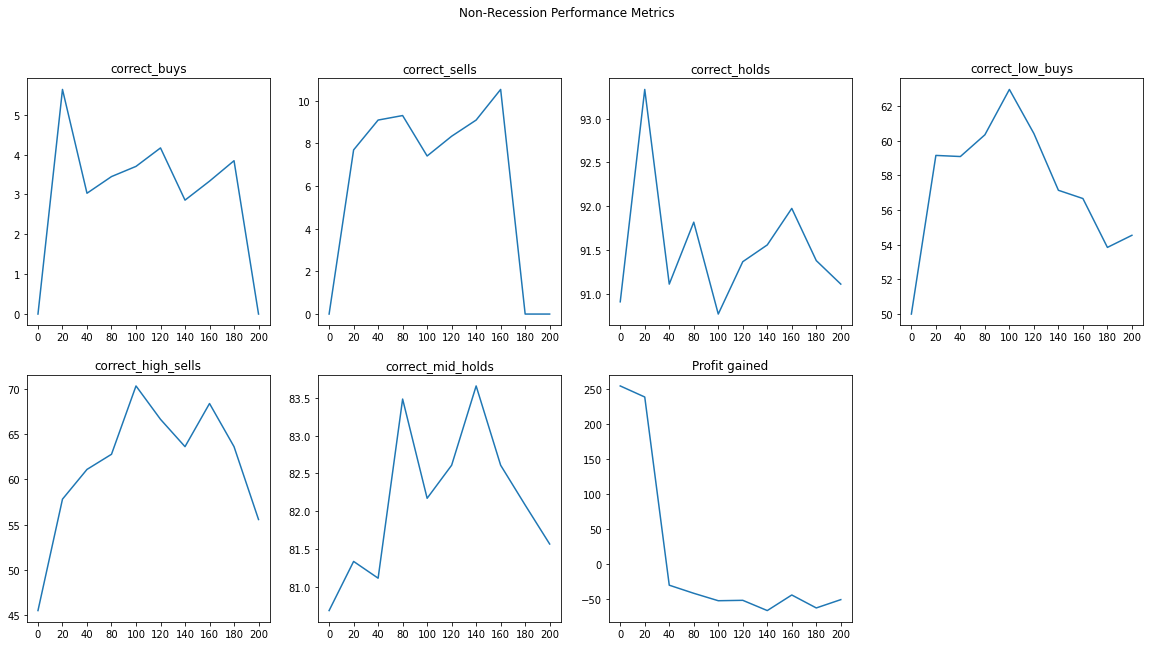

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

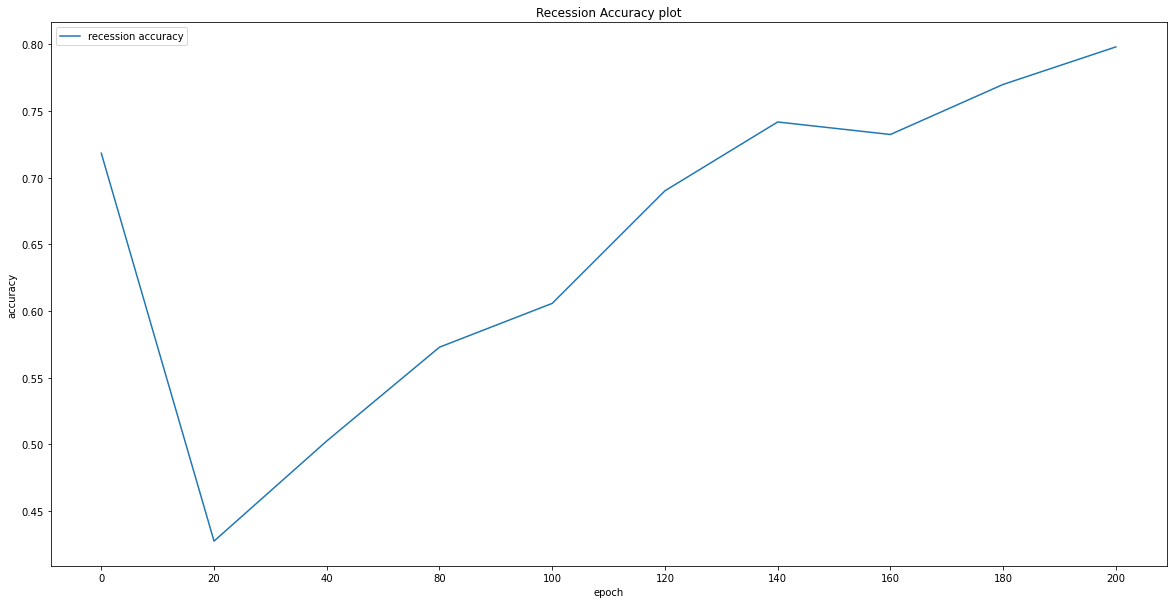

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

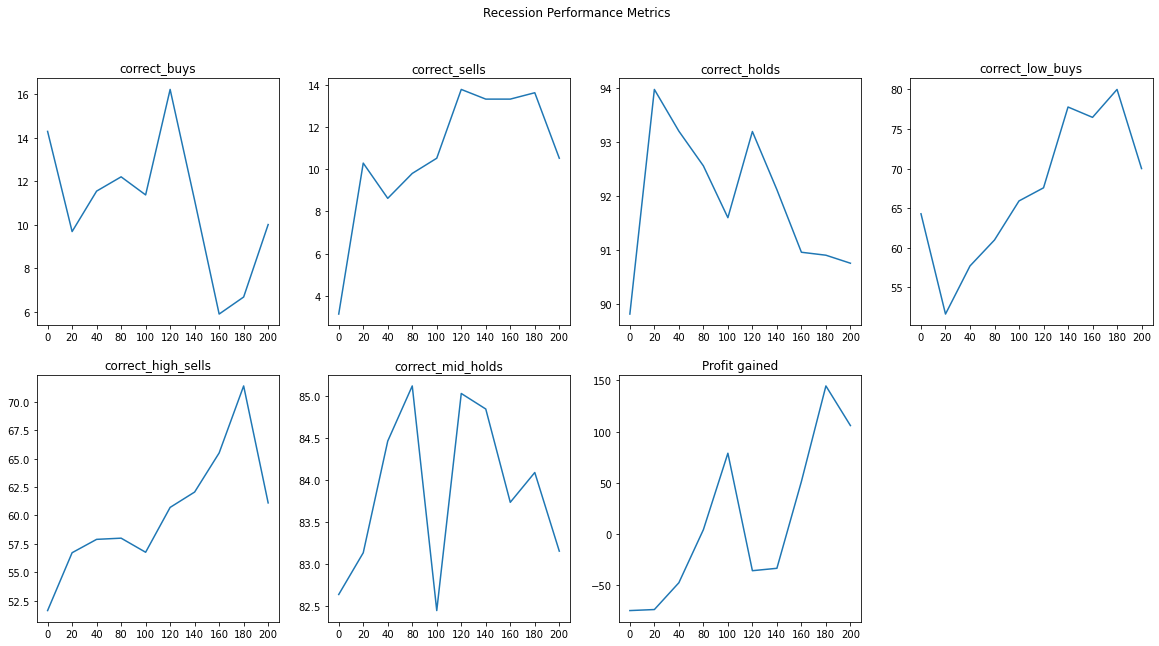

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [47]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-01-29   103.879997  102.341518 -16.190536   93054100.0     2.0
2019-01-30   104.169998  102.622823 -14.439357  102797400.0     2.0
2019-01-31   104.410004  102.897774 -12.499914  115323700.0     2.0
2019-02-01   103.500000  102.990424 -26.204790   97803100.0     2.0
2019-02-04   103.879997  103.127281 -20.481939  110803900.0     2.0


In [48]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-29   134.429993  135.764759 -57.285148   1917800.0     2.0
2020-01-30   134.229996  135.528641 -59.095077  -7408200.0     2.0
2020-01-31   135.889999  135.584235 -44.072403   1640700.0     2.0
2020-02-03   132.360001  135.088199 -76.018128 -11144500.0     2.0
2020-02-04   133.369995  134.823860 -66.877896  -1123400.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


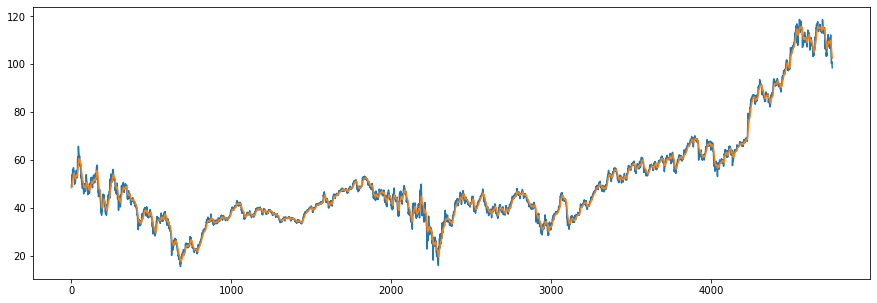

In [49]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 10, 4)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.6767676767676765, 1: 7.407407407407407, 2: 0.36566589684372597}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 41ms/step - loss: 0.2924 - accuracy: 0.4611 - mse: 0.4649 - weighted_accuracy: 0.3509 - weighted_mse: 0.5136 - val_loss: 0.2998 - val_accuracy: 0.0453 - val_mse: 0.3509 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3509
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2059 - accuracy: 0.3366 - mse: 0.7740 - weighted_accuracy: 0.5007 - weighted_mse: 0.7355 - val_loss: 0.2905 - val_accuracy: 0.0453 - val_mse: 0.3798 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3798
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.2673 - mse: 1.0235 - weighted_accuracy: 0.5287 - weighted_mse: 0.961 - 0s 8ms/step - loss: 0.1808 - accuracy: 0.2732 - mse: 1.0431 - weighted_accuracy: 0.5471 - weighted_mse: 0.9835 - val_loss: 0.2788 - val_accuracy: 0.0453 - val_mse: 0.4173 - val_

7/7 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.3562 - mse: 1.3500 - weighted_accuracy: 0.3562 - weighted_mse: 1.3500
Test loss: 0.18505927920341492
Test accuracy: 0.3561643958091736


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 76
actual predicted holds: 64
Percentage buys correct: 8.064516129032258%
Percentage sells correct: 10.588235294117647%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.16129032258065%
Percentage high sells correct: 55.294117647058826%
Percentage mid holds correct: 85.91549295774648%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price 

30/30 [==============================] - 0s 7ms/step - loss: 0.1267 - accuracy: 0.4674 - mse: 1.8694 - weighted_accuracy: 0.7481 - weighted_mse: 1.8067 - val_loss: 0.1866 - val_accuracy: 0.4168 - val_mse: 1.9872 - val_weighted_accuracy: 0.4168 - val_weighted_mse: 1.9872
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1256 - accuracy: 0.4729 - mse: 1.8810 - weighted_accuracy: 0.7467 - weighted_mse: 1.8201 - val_loss: 0.1845 - val_accuracy: 0.3958 - val_mse: 1.9576 - val_weighted_accuracy: 0.3958 - val_weighted_mse: 1.9576
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1257 - accuracy: 0.4821 - mse: 1.8854 - weighted_accuracy: 0.7575 - weighted_mse: 1.8254 - val_loss: 0.1906 - val_accuracy: 0.3863 - val_mse: 2.0757 - val_weighted_accuracy: 0.3863 - val_weighted_mse: 2.0757
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1254 - accuracy: 0.4568 - mse: 1.9676 - weighted_accuracy: 0.7521 - weighted_mse: 1.8896

Shares owned at the moment: 0
Cash capital at the moment: $16.363463802830697


Share price: $0.36340009387635375
Shares owned at the moment: 44
Cash capital at the moment: $0.32988826091209233


Price increase from previously bought: -40.2488821900428%
Share price: $0.2177327411636425
Shares owned at the moment: 0
Cash capital at the moment: $9.883783210431561


Share price: $0.30235200113438254
Shares owned at the moment: 32
Cash capital at the moment: $0.18191219803149394


Price increase from previously bought: 10.576650692508593%
Share price: $0.3352501256256053
Shares owned at the moment: 0
Cash capital at the moment: $10.88041420699581


Share price: $0.29014251196354235
Shares owned at the moment: 37
Cash capital at the moment: $0.11561926375245335


Price increase from previously bought: 22.049287879201728%
Share price: $0.35509069107796853
Shares owned at the moment: 0
Cash capital at the moment: $13.217844355820105


Share price: $0.34101583633014876
Shares owned at the mome

30/30 [==============================] - 0s 14ms/step - loss: 0.1013 - accuracy: 0.6332 - mse: 2.4517 - weighted_accuracy: 0.8358 - weighted_mse: 2.4148 - val_loss: 0.1633 - val_accuracy: 0.5726 - val_mse: 2.5506 - val_weighted_accuracy: 0.5726 - val_weighted_mse: 2.5506
Epoch 20/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1007 - accuracy: 0.6255 - mse: 2.4932 - weighted_accuracy: 0.8366 - weighted_mse: 2.4576 - val_loss: 0.1643 - val_accuracy: 0.5611 - val_mse: 2.6973 - val_weighted_accuracy: 0.5611 - val_weighted_mse: 2.6973
Validation loss: 0.16432254016399384
Validation accuracy: 0.5610526204109192


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.5963 - mse: 2.8717 - weighted_accuracy: 0.5963 - weighted_mse: 2.8717
Test loss: 0.1624475121498108
Test accuracy: 0.5963302850723267


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual s

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0991 - accuracy: 0.6403 - mse: 2.4428 - weighted_accuracy: 0.8458 - weighted_mse: 2.4102 - val_loss: 0.1587 - val_accuracy: 0.5874 - val_mse: 2.6226 - val_weighted_accuracy: 0.5874 - val_weighted_mse: 2.6226
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0984 - accuracy: 0.6637 - mse: 2.4681 - weighted_accuracy: 0.8524 - weighted_mse: 2.4427 - val_loss: 0.1755 - val_accuracy: 0.5326 - val_mse: 2.6627 - val_weighted_accuracy: 0.5326 - val_weighted_mse: 2.6627
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0973 - accuracy: 0.6324 - mse: 2.5423 - weighted_accuracy: 0.8447 - weighted_mse: 2.5063 - val_loss: 0.1753 - val_accuracy: 0.5432 - val_mse: 2.6627 - val_weighted_accuracy: 0.5432 - val_weighted_mse: 2.6627
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0972 - accuracy: 0.6524 - mse: 2.5876 - weighted_accuracy: 0.8520 - weighted

7/7 [==============================] - 0s 7ms/step - loss: 0.1400 - accuracy: 0.6804 - mse: 3.1386 - weighted_accuracy: 0.6804 - weighted_mse: 3.1386
Test loss: 0.13999128341674805
Test accuracy: 0.6803653240203857


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 28
actual holds but predicted sell: 25
actual predicted holds: 144
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 89.44099378881988%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.57142857142857%
Percentage mid holds correct: 80.625%


Capital: 100
Share price: $0.9109666573342325
Shares owned at the moment: 109
Cash capital at the moment: $0.4315720950327204


Price increase from previous

Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.7897 - mse: 3.9155 - weighted_accuracy: 0.9119 - weighted_mse: 3.7743 - val_loss: 0.1617 - val_accuracy: 0.6695 - val_mse: 4.0801 - val_weighted_accuracy: 0.6695 - val_weighted_mse: 4.0801
Epoch 20/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0665 - accuracy: 0.7903 - mse: 3.9799 - weighted_accuracy: 0.9140 - weighted_mse: 3.8327 - val_loss: 0.1557 - val_accuracy: 0.6958 - val_mse: 4.4129 - val_weighted_accuracy: 0.6958 - val_weighted_mse: 4.4129
Validation loss: 0.15568575263023376
Validation accuracy: 0.6957894563674927


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1483 - accuracy: 0.7202 - mse: 4.7209 - weighted_accuracy: 0.7202 - weighted_mse: 4.7209
Test loss: 0.148334801197052
Test accuracy: 0.7201834917068481


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 

30/30 [==============================] - 0s 15ms/step - loss: 0.0613 - accuracy: 0.8126 - mse: 4.3582 - weighted_accuracy: 0.9278 - weighted_mse: 4.1467 - val_loss: 0.1853 - val_accuracy: 0.6379 - val_mse: 4.6788 - val_weighted_accuracy: 0.6379 - val_weighted_mse: 4.6788
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0611 - accuracy: 0.8084 - mse: 4.2893 - weighted_accuracy: 0.9262 - weighted_mse: 4.1097 - val_loss: 0.1930 - val_accuracy: 0.6295 - val_mse: 4.7958 - val_weighted_accuracy: 0.6295 - val_weighted_mse: 4.7958
Epoch 9/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0596 - accuracy: 0.8213 - mse: 4.3781 - weighted_accuracy: 0.9309 - weighted_mse: 4.1405 - val_loss: 0.1527 - val_accuracy: 0.7305 - val_mse: 4.6925 - val_weighted_accuracy: 0.7305 - val_weighted_mse: 4.6925
Epoch 10/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0601 - accuracy: 0.8063 - mse: 4.4419 - weighted_accuracy: 0.9255 - weighted_mse: 4.21

Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0511 - accuracy: 0.8487 - mse: 5.0904 - weighted_accuracy: 0.9428 - weighted_mse: 4.7276 - val_loss: 0.1596 - val_accuracy: 0.7526 - val_mse: 5.7364 - val_weighted_accuracy: 0.7526 - val_weighted_mse: 5.7364
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0512 - accuracy: 0.8645 - mse: 5.1772 - weighted_accuracy: 0.9467 - weighted_mse: 4.7914 - val_loss: 0.1882 - val_accuracy: 0.6821 - val_mse: 5.5253 - val_weighted_accuracy: 0.6821 - val_weighted_mse: 5.5253
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0505 - accuracy: 0.8395 - mse: 5.2557 - weighted_accuracy: 0.9375 - weighted_mse: 4.9126 - val_loss: 0.2165 - val_accuracy: 0.6179 - val_mse: 5.7112 - val_weighted_accuracy: 0.6179 - val_weighted_mse: 5.7112
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0512 - accuracy: 0.8492 - mse: 5.4357 - weighted_accuracy: 0.9449 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1702 - accuracy: 0.7763 - mse: 6.4375 - weighted_accuracy: 0.7763 - weighted_mse: 6.4375
Test loss: 0.17020238935947418
Test accuracy: 0.77625572681427


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 21
actual predicted holds: 164
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 16.0%
Percentage holds correct: 91.11111111111111%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 64.28571428571429%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 83.24022346368714%


Capital: 100
Share price: $0.7279922518370321
Shares owned at the moment: 136
Cash capital at the moment: $0.7207846479765863


Price increase from previously b

Epoch 20/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0333 - accuracy: 0.9055 - mse: 8.2714 - weighted_accuracy: 0.9617 - weighted_mse: 7.1851 - val_loss: 0.1951 - val_accuracy: 0.7800 - val_mse: 9.2824 - val_weighted_accuracy: 0.7800 - val_weighted_mse: 9.2824
Validation loss: 0.1950521171092987
Validation accuracy: 0.7799999713897705


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1765 - accuracy: 0.8165 - mse: 9.8984 - weighted_accuracy: 0.8165 - weighted_mse: 9.8984
Test loss: 0.1765151470899582
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 3
actual holds but predicted sell: 20
actual predicted holds: 178
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 

30/30 [==============================] - 0s 12ms/step - loss: 0.0325 - accuracy: 0.9095 - mse: 9.3470 - weighted_accuracy: 0.9650 - weighted_mse: 8.0916 - val_loss: 0.2064 - val_accuracy: 0.7800 - val_mse: 9.5362 - val_weighted_accuracy: 0.7800 - val_weighted_mse: 9.5362
Epoch 13/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0275 - accuracy: 0.9371 - mse: 9.3370 - weighted_accuracy: 0.9770 - weighted_mse: 8.0191 - val_loss: 0.2105 - val_accuracy: 0.7884 - val_mse: 10.0338 - val_weighted_accuracy: 0.7884 - val_weighted_mse: 10.0338
Epoch 14/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0285 - accuracy: 0.9292 - mse: 9.5451 - weighted_accuracy: 0.9741 - weighted_mse: 8.0917 - val_loss: 0.2156 - val_accuracy: 0.7495 - val_mse: 9.9725 - val_weighted_accuracy: 0.7495 - val_weighted_mse: 9.9725
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0290 - accuracy: 0.9289 - mse: 9.5953 - weighted_accuracy: 0.9703 - weighted_mse: 

30/30 [==============================] - 0s 11ms/step - loss: 0.0268 - accuracy: 0.9353 - mse: 10.6674 - weighted_accuracy: 0.9763 - weighted_mse: 8.9546 - val_loss: 0.2338 - val_accuracy: 0.7558 - val_mse: 11.1223 - val_weighted_accuracy: 0.7558 - val_weighted_mse: 11.1223
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9429 - mse: 10.5915 - weighted_accuracy: 0.9791 - weighted_mse: 8.9125 - val_loss: 0.2299 - val_accuracy: 0.7484 - val_mse: 11.0484 - val_weighted_accuracy: 0.7484 - val_weighted_mse: 11.0484
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.9468 - mse: 10.8284 - weighted_accuracy: 0.9806 - weighted_mse: 8.9597 - val_loss: 0.2357 - val_accuracy: 0.7642 - val_mse: 10.9626 - val_weighted_accuracy: 0.7642 - val_weighted_mse: 10.9626
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9453 - mse: 11.0141 - weighted_accuracy: 0.9800 - weighted_mse

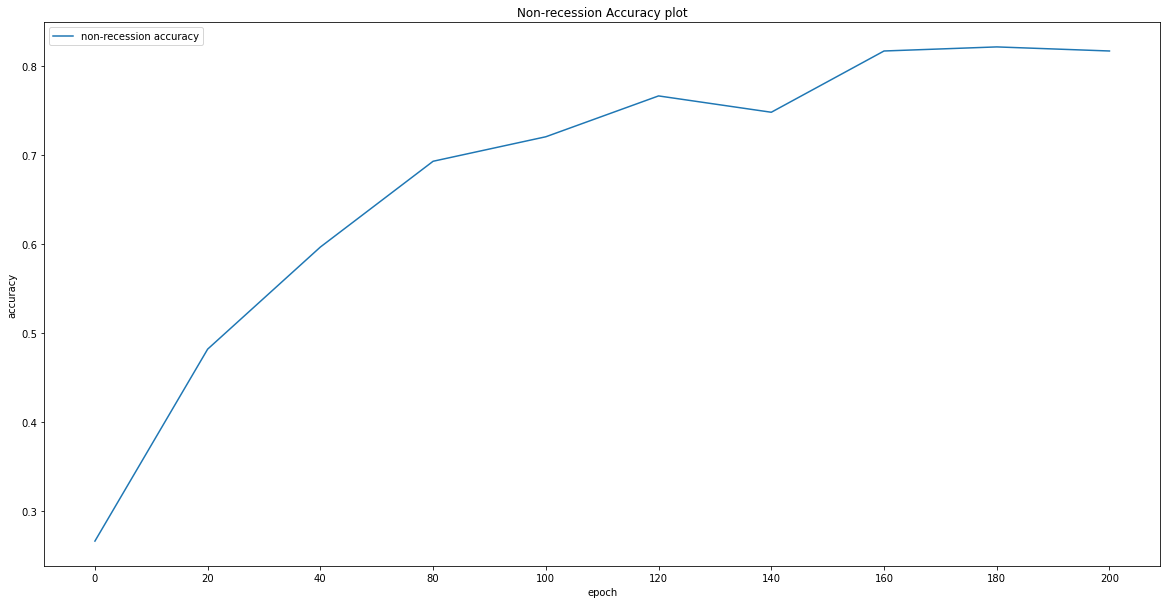

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

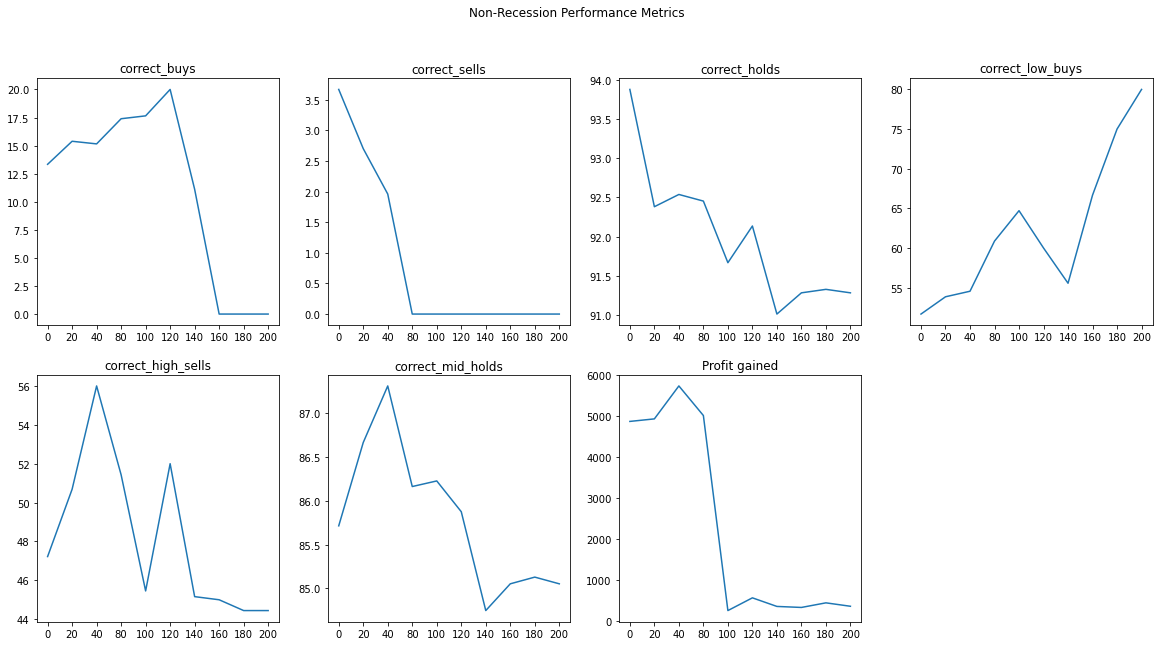

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

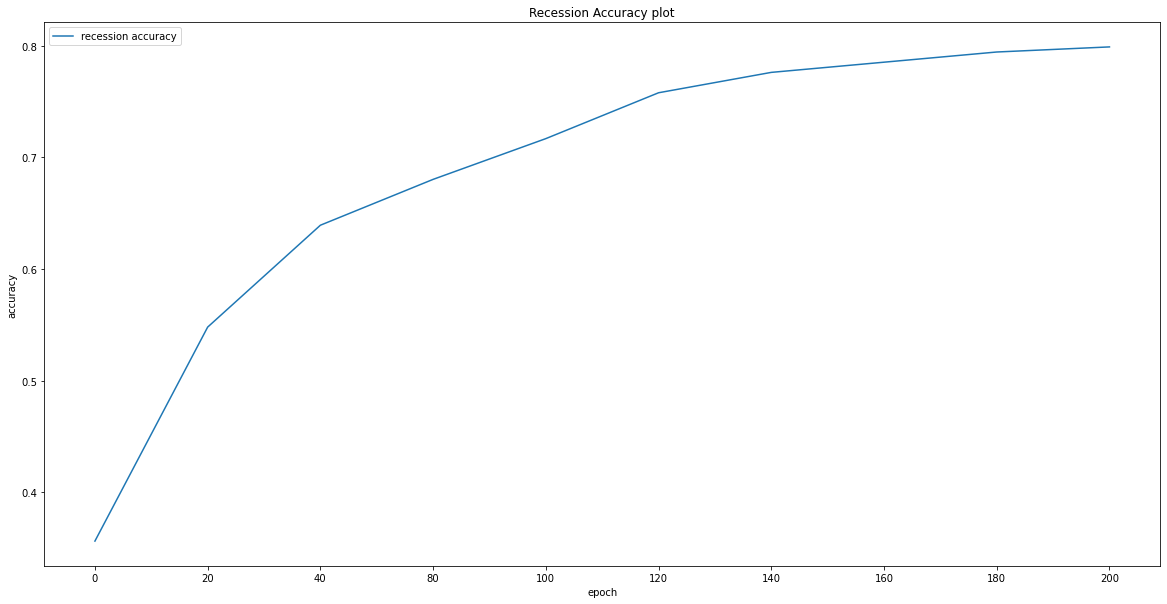

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

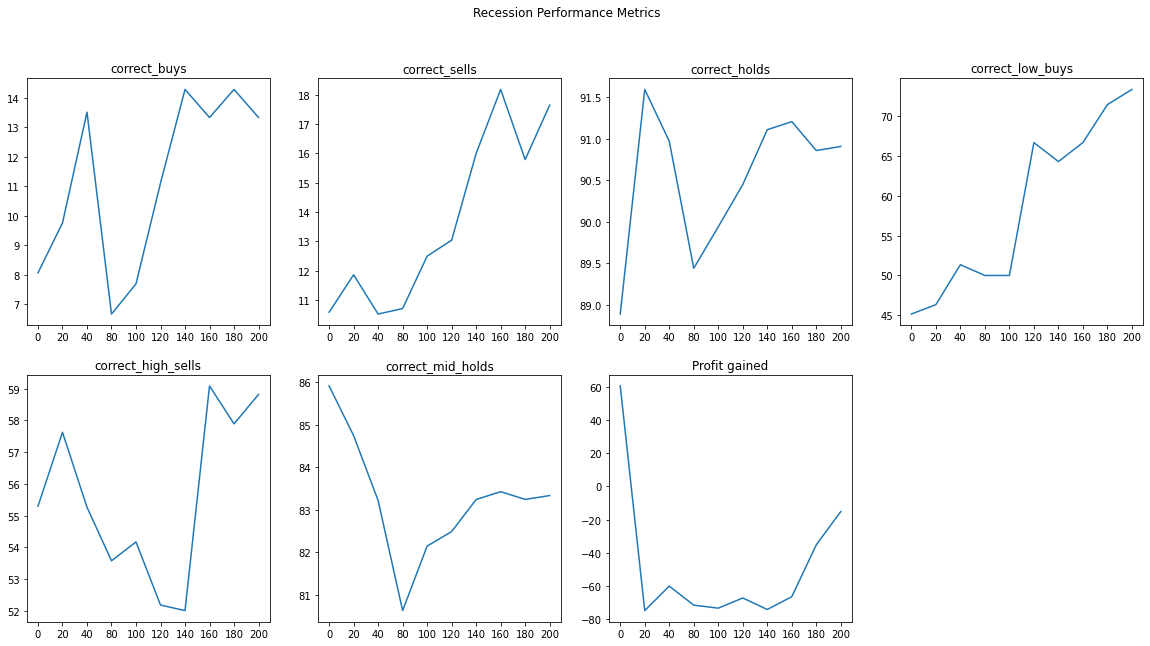

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [59]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-29        14.43  13.836690 -16.988400  21013100.0     2.0
2019-01-30        14.33  13.912584 -22.131150  19773800.0     2.0
2019-01-31        14.59  14.016802 -11.475401  20659500.0     2.0
2019-02-01        14.78  14.134217  -4.017864  22103800.0     2.0
2019-02-04        14.92  14.255106  -6.278041  23682100.0     0.0


In [60]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[5:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_10 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 9:
            data_10.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_10_arr = min_max_scaler.fit_transform(data_10)
            sequential.append(data_10_arr)
            data_10 = data_10[1:10]
        else:
            data_10.append(np.array(i[0:-1]))
            count+= 1     
        
    X  = np.array(sequential).reshape(-1, 10, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-29         9.56  9.554791 -45.714255  -464900.0     2.0
2020-01-30         9.44  9.537131 -47.107490 -1769800.0     2.0
2020-01-31         9.41  9.517572 -49.586807 -2999800.0     1.0
2020-02-03         9.24  9.474869 -63.636399 -4264900.0     2.0
2020-02-04         9.45  9.471043 -51.851894 -2731100.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


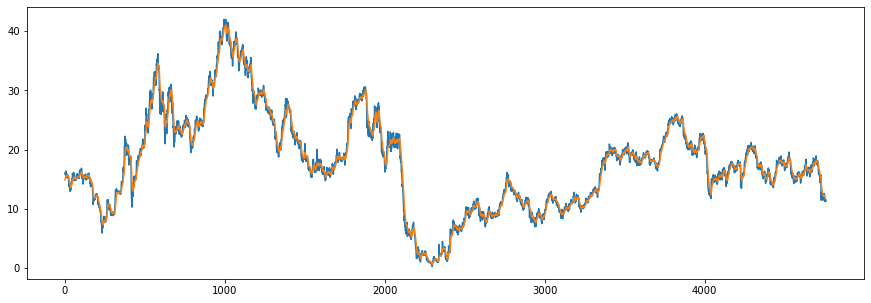

In [61]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

X  = np.array(sequential).reshape(-1, 10, 4)
y = labels
y = np.array(y)

In [62]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [63]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [64]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [66]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2796934865900385, 1: 7.2796934865900385, 2: 0.36693704132869837}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 46ms/step - loss: 0.2953 - accuracy: 0.4624 - mse: 0.4644 - weighted_accuracy: 0.3443 - weighted_mse: 0.5169 - val_loss: 0.2996 - val_accuracy: 0.0463 - val_mse: 0.3510 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3510
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2086 - accuracy: 0.3011 - mse: 0.7864 - weighted_accuracy: 0.4652 - weighted_mse: 0.7376 - val_loss: 0.2909 - val_accuracy: 0.0463 - val_mse: 0.3816 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3816
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1851 - accuracy: 0.2645 - mse: 1.0361 - weighted_accuracy: 0.5136 - weighted_mse: 0.9656 - val_loss: 0.2794 - val_accuracy: 0.0463 - val_mse: 0.4199 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.4199
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.3790 - mse: 1.3405 - weighted_accuracy: 0.3790 - weighted_mse: 1.3405
Test loss: 0.1807747483253479
Test accuracy: 0.37899544835090637


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 40
actual holds but predicted sell: 84
actual predicted holds: 73
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 87.95180722891567%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 82.92682926829268%


Capital: 100
Share price: $0.5126315607027336
Shares owned at the moment: 194
Cash capital at the moment: $0.2759882860347602


Price

Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1299 - accuracy: 0.4545 - mse: 1.7854 - weighted_accuracy: 0.7398 - weighted_mse: 1.7186 - val_loss: 0.1835 - val_accuracy: 0.4326 - val_mse: 1.9191 - val_weighted_accuracy: 0.4326 - val_weighted_mse: 1.9191
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1280 - accuracy: 0.4468 - mse: 1.8136 - weighted_accuracy: 0.7425 - weighted_mse: 1.7493 - val_loss: 0.2011 - val_accuracy: 0.3663 - val_mse: 1.8876 - val_weighted_accuracy: 0.3663 - val_weighted_mse: 1.8876
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1290 - accuracy: 0.4553 - mse: 1.8281 - weighted_accuracy: 0.7364 - weighted_mse: 1.7655 - val_loss: 0.1857 - val_accuracy: 0.4253 - val_mse: 1.9586 - val_weighted_accuracy: 0.4253 - val_weighted_mse: 1.9586
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1259 - accuracy: 0.4645 - mse: 1.8519 - weighted_accuracy: 0.7617 - weighted


Percentage low buys correct: 59.57446808510638%
Percentage high sells correct: 62.71186440677966%
Percentage mid holds correct: 83.92857142857143%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bought: -80.1473547855927%
Share price: $0.14684209766810635
Shares owned at the moment: 0
Cash capital at the moment: $19.915053045060827


Share price: $0.07447368425180377
Shares owned at the moment: 266
Cash capital at the moment: $0.05057553405082871


Price increase from previously bought: 175.91966273370593%
Share price: $0.20605262914357764
Shares owned at the moment: 0
Cash capital at the moment: $54.70984738802395


Share price: $0.08499998980446886
Shares owned at the moment: 641
Cash capital at the moment: $0.075020191331582


Price increase from previously bought: 86.17532426839962%
Share price: $0.15868419141485463
Shares owned at the moment: 0
Cash capital at the mome

Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.5655 - mse: 2.2168 - weighted_accuracy: 0.8024 - weighted_mse: 2.2317 - val_loss: 0.1869 - val_accuracy: 0.4758 - val_mse: 2.3963 - val_weighted_accuracy: 0.4758 - val_weighted_mse: 2.3963
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1067 - accuracy: 0.5903 - mse: 2.2381 - weighted_accuracy: 0.8224 - weighted_mse: 2.2601 - val_loss: 0.1703 - val_accuracy: 0.5400 - val_mse: 2.2375 - val_weighted_accuracy: 0.5400 - val_weighted_mse: 2.2375
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1070 - accuracy: 0.5842 - mse: 2.2684 - weighted_accuracy: 0.8110 - weighted_mse: 2.2805 - val_loss: 0.1779 - val_accuracy: 0.5221 - val_mse: 2.2888 - val_weighted_accuracy: 0.5221 - val_weighted_mse: 2.2888
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1071 - accuracy: 0.6013 - mse: 2.2875 - weighted_accuracy: 0.8155 - weighted

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1030 - accuracy: 0.6189 - mse: 2.3884 - weighted_accuracy: 0.8256 - weighted_mse: 2.4295 - val_loss: 0.1796 - val_accuracy: 0.5011 - val_mse: 2.5089 - val_weighted_accuracy: 0.5011 - val_weighted_mse: 2.5089
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1019 - accuracy: 0.6224 - mse: 2.4271 - weighted_accuracy: 0.8360 - weighted_mse: 2.4868 - val_loss: 0.1776 - val_accuracy: 0.5389 - val_mse: 2.5237 - val_weighted_accuracy: 0.5389 - val_weighted_mse: 2.5237
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1009 - accuracy: 0.6253 - mse: 2.4417 - weighted_accuracy: 0.8316 - weighted_mse: 2.4957 - val_loss: 0.1914 - val_accuracy: 0.4737 - val_mse: 2.5621 - val_weighted_accuracy: 0.4737 - val_weighted_mse: 2.5621
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.6292 - mse: 2.4588 - weighted_accuracy: 0.8385 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1487 - accuracy: 0.6119 - mse: 2.6831 - weighted_accuracy: 0.6119 - weighted_mse: 2.6831
Test loss: 0.14874833822250366
Test accuracy: 0.611872136592865


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 29
actual holds but predicted sell: 41
actual predicted holds: 127
Percentage buys correct: 14.705882352941176%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 89.43661971830986%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 61.76470588235294%
Percentage high sells correct: 55.81395348837209%
Percentage mid holds correct: 83.68794326241135%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price

30/30 [==============================] - 0s 8ms/step - loss: 0.0798 - accuracy: 0.7405 - mse: 3.3975 - weighted_accuracy: 0.8921 - weighted_mse: 3.5651 - val_loss: 0.1658 - val_accuracy: 0.6326 - val_mse: 3.8523 - val_weighted_accuracy: 0.6326 - val_weighted_mse: 3.8523
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.7408 - mse: 3.4480 - weighted_accuracy: 0.8903 - weighted_mse: 3.6145 - val_loss: 0.1871 - val_accuracy: 0.5705 - val_mse: 3.5780 - val_weighted_accuracy: 0.5705 - val_weighted_mse: 3.5780
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.7416 - mse: 3.4381 - weighted_accuracy: 0.8852 - weighted_mse: 3.5970 - val_loss: 0.1993 - val_accuracy: 0.5358 - val_mse: 3.5840 - val_weighted_accuracy: 0.5358 - val_weighted_mse: 3.5840
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0735 - accuracy: 0.7576 - mse: 3.4908 - weighted_accuracy: 0.9020 - weighted_mse: 3.6660

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0718 - accuracy: 0.7750 - mse: 3.7419 - weighted_accuracy: 0.9083 - weighted_mse: 3.9121 - val_loss: 0.1706 - val_accuracy: 0.6211 - val_mse: 3.9117 - val_weighted_accuracy: 0.6211 - val_weighted_mse: 3.9117
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0704 - accuracy: 0.7805 - mse: 3.7792 - weighted_accuracy: 0.9122 - weighted_mse: 3.9784 - val_loss: 0.1721 - val_accuracy: 0.6337 - val_mse: 4.0721 - val_weighted_accuracy: 0.6337 - val_weighted_mse: 4.0721
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0697 - accuracy: 0.7884 - mse: 3.8128 - weighted_accuracy: 0.9133 - weighted_mse: 3.9930 - val_loss: 0.2184 - val_accuracy: 0.5179 - val_mse: 3.8994 - val_weighted_accuracy: 0.5179 - val_weighted_mse: 3.8994
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0704 - accuracy: 0.7811 - mse: 3.7722 - weighted_accuracy: 0.9087 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.7260 - mse: 4.2263 - weighted_accuracy: 0.7260 - weighted_mse: 4.2263
Test loss: 0.1368809938430786
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 17
actual holds but predicted sell: 25
actual predicted holds: 155
Percentage buys correct: 15.0%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 89.59537572254335%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.13953488372093%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bought: -80.

30/30 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.8447 - mse: 5.3399 - weighted_accuracy: 0.9376 - weighted_mse: 5.4572 - val_loss: 0.1927 - val_accuracy: 0.6579 - val_mse: 5.4706 - val_weighted_accuracy: 0.6579 - val_weighted_mse: 5.4706
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0490 - accuracy: 0.8605 - mse: 5.4318 - weighted_accuracy: 0.9488 - weighted_mse: 5.5903 - val_loss: 0.1700 - val_accuracy: 0.7126 - val_mse: 5.7798 - val_weighted_accuracy: 0.7126 - val_weighted_mse: 5.7798
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.8542 - mse: 5.4223 - weighted_accuracy: 0.9429 - weighted_mse: 5.5006 - val_loss: 0.1813 - val_accuracy: 0.6905 - val_mse: 5.3782 - val_weighted_accuracy: 0.6905 - val_weighted_mse: 5.3782
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0485 - accuracy: 0.8676 - mse: 5.5367 - weighted_accuracy: 0.9478 - weighted_mse: 5.6736

30/30 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.8684 - mse: 5.7813 - weighted_accuracy: 0.9517 - weighted_mse: 5.8863 - val_loss: 0.1775 - val_accuracy: 0.7137 - val_mse: 6.0791 - val_weighted_accuracy: 0.7137 - val_weighted_mse: 6.0791
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.8616 - mse: 5.8114 - weighted_accuracy: 0.9474 - weighted_mse: 5.9557 - val_loss: 0.1783 - val_accuracy: 0.6989 - val_mse: 6.0002 - val_weighted_accuracy: 0.6989 - val_weighted_mse: 6.0002
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0457 - accuracy: 0.8745 - mse: 5.9192 - weighted_accuracy: 0.9485 - weighted_mse: 6.0426 - val_loss: 0.2192 - val_accuracy: 0.6000 - val_mse: 5.8123 - val_weighted_accuracy: 0.6000 - val_weighted_mse: 5.8123
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0464 - accuracy: 0.8697 - mse: 5.9315 - weighted_accuracy: 0.9449 - weighted_mse: 6.0417 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.7854 - mse: 6.4523 - weighted_accuracy: 0.7854 - weighted_mse: 6.4523
Test loss: 0.15389347076416016
Test accuracy: 0.7853881120681763


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 13
actual holds but predicted sell: 16
actual predicted holds: 168
Percentage buys correct: 18.75%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.3225806451613%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.25%
Percentage high sells correct: 58.8235294117647%
Percentage mid holds correct: 84.32432432432432%


Capital: 100
Share price: $0.7021052488758956
Shares owned at the moment: 142
Cash capital at the moment: $0.026882559936780126


Price increase from previous

Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 0.9158 - mse: 8.2832 - weighted_accuracy: 0.9636 - weighted_mse: 7.9936 - val_loss: 0.2040 - val_accuracy: 0.7442 - val_mse: 8.4321 - val_weighted_accuracy: 0.7442 - val_weighted_mse: 8.4321
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9137 - mse: 8.2343 - weighted_accuracy: 0.9629 - weighted_mse: 7.9534 - val_loss: 0.1989 - val_accuracy: 0.7663 - val_mse: 8.7521 - val_weighted_accuracy: 0.7663 - val_weighted_mse: 8.7521
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 0.9187 - mse: 8.4500 - weighted_accuracy: 0.9647 - weighted_mse: 8.1468 - val_loss: 0.1921 - val_accuracy: 0.7863 - val_mse: 8.4149 - val_weighted_accuracy: 0.7863 - val_weighted_mse: 8.4149
Validation loss: 0.19211263954639435
Validation accuracy: 0.7863157987594604


Non-Recession Test


7/7 [==============================] - 0s 3ms/step 

30/30 [==============================] - 0s 8ms/step - loss: 0.0301 - accuracy: 0.9218 - mse: 9.1342 - weighted_accuracy: 0.9713 - weighted_mse: 8.8479 - val_loss: 0.2122 - val_accuracy: 0.7642 - val_mse: 9.7974 - val_weighted_accuracy: 0.7642 - val_weighted_mse: 9.7974
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9274 - mse: 9.2471 - weighted_accuracy: 0.9733 - weighted_mse: 8.7614 - val_loss: 0.2271 - val_accuracy: 0.7116 - val_mse: 8.6789 - val_weighted_accuracy: 0.7116 - val_weighted_mse: 8.6789
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0297 - accuracy: 0.9255 - mse: 9.1142 - weighted_accuracy: 0.9709 - weighted_mse: 8.8081 - val_loss: 0.1964 - val_accuracy: 0.7747 - val_mse: 8.4605 - val_weighted_accuracy: 0.7747 - val_weighted_mse: 8.4605
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9211 - mse: 9.3473 - weighted_accuracy: 0.9710 - weighted_mse: 8.9370 -

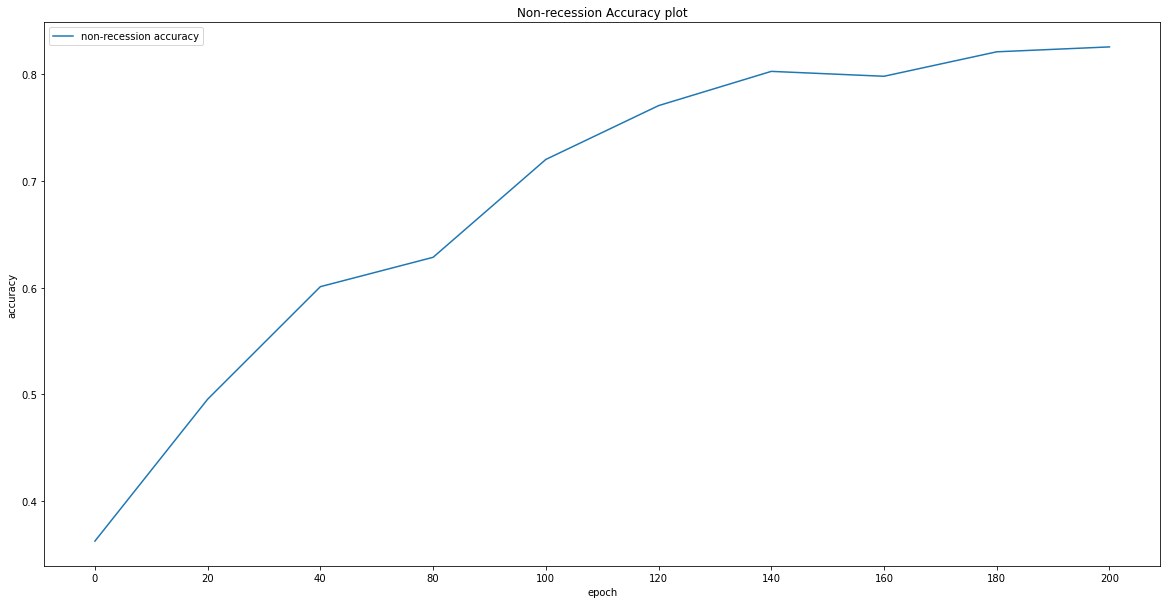

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

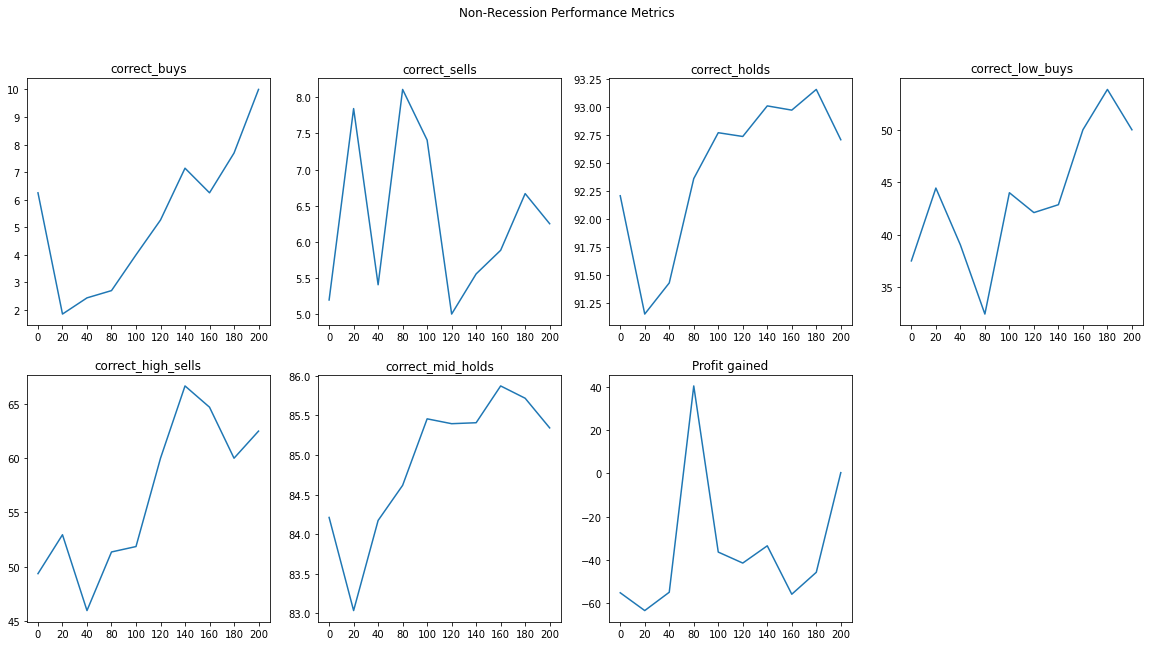

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

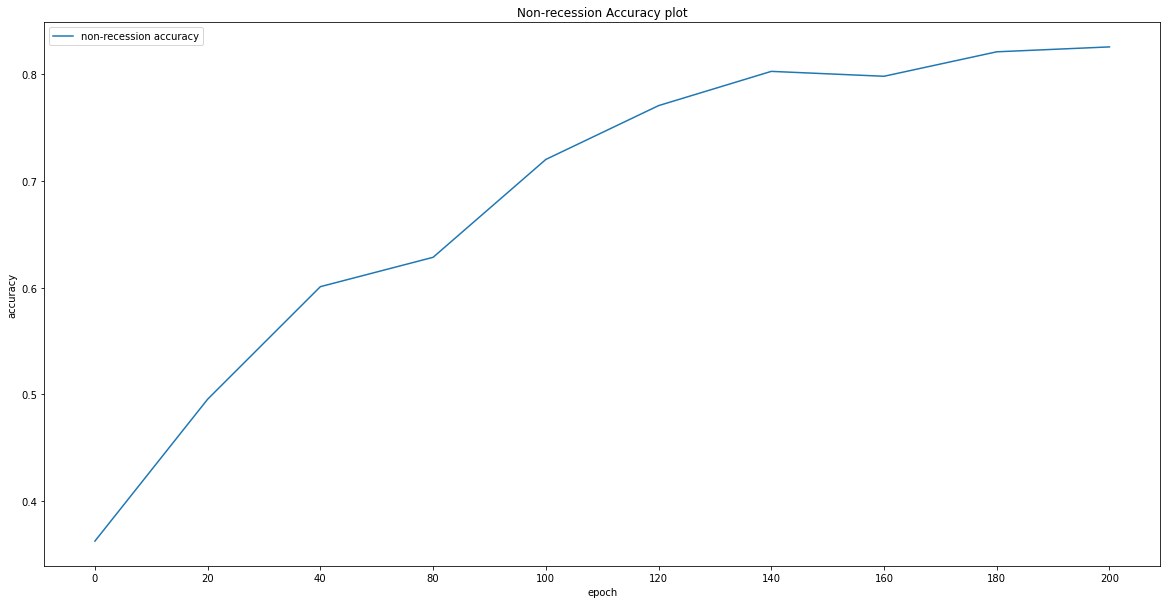

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

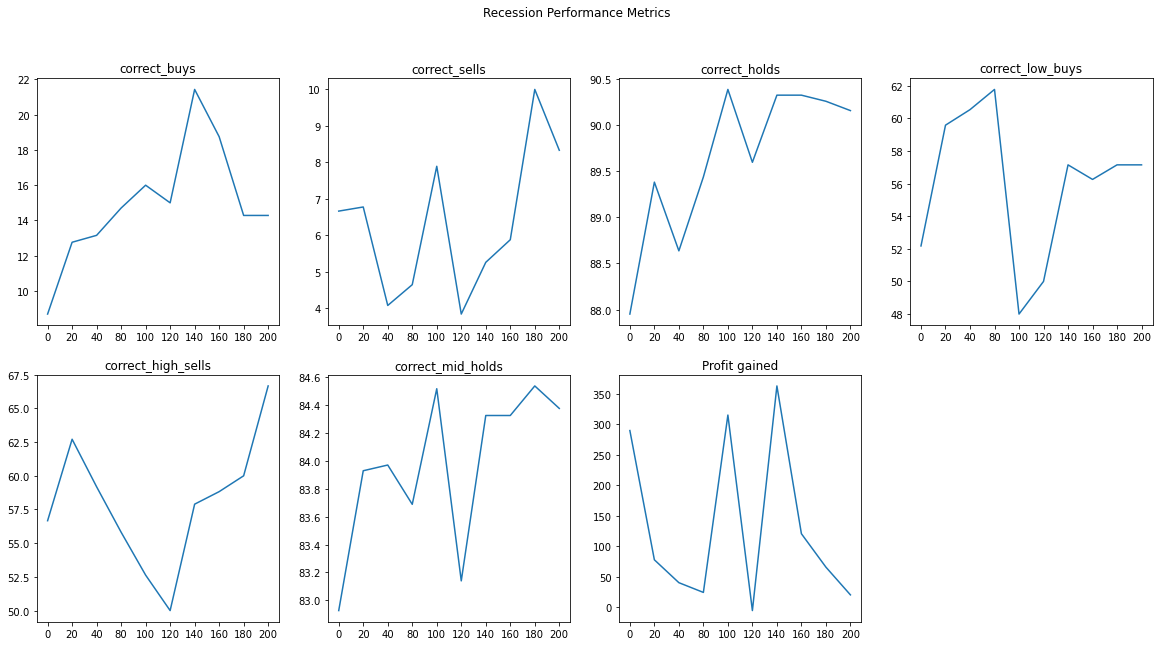

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")